
# Preprocessing

#1. Import packages that are used throughout the experiment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
import  sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from math import radians, sin, cos, sqrt, atan2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, roc_auc_score
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
#!pip install imblearn


#2. Read data

In [3]:
train_file_path = 'fraudTrain.csv'
test_file_path = 'fraudTest.csv'

train_data = pd.read_csv(train_file_path) # reading the train data
test_data = pd.read_csv(test_file_path) # reading the test data

#3. check the data 

In [4]:
#check train test ratio
a = len(train_data)
b = len(test_data)
total = a+b
print('Number of records in the train dataset : ',a)
print('Number of records in the test dataset : ',b)
print('Train vs Test ratio : ', 100*round(a/total,1),'% : ',100*round(b/total,1),'%')


Number of records in the train dataset :  1296675
Number of records in the test dataset :  555719
Train vs Test ratio :  70.0 % :  30.0 %


In [5]:
##Add split label, so we can concantenate the data, and later split it back into their original shape

train_data['split_label'] = 'train' 
test_data['split_label'] = 'test'
data = pd.concat([train_data,test_data], axis = 0)
data_copy = data.copy()

In [6]:
data.shape

(1852394, 24)

In [7]:
data.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
split_label               object
dtype: object

In [8]:
data.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
split_label              0
dtype: int64

In [9]:
data.head(3)


Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant       category     amt      first     last  \
0       fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer    Banks   
1  fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie     Gill   
2             fraud_Lind-Buckridge  entertainment  220.11     Edward  Sanchez   

  gender                        street  ...      long city_pop  \
0      F                561 Perry Cove  ...  -81.1781     3495   
1      F  43039 Riley Greens Suite 393  ... -118.2105      149   
2      M      594 White Dale Suite 530  ... -112.2620     4154   

                                 job         dob  \
0          Psychologist, counselling  1988-03-09   
1  Special educational needs teacher  1978-06-21   
2        Nature conservation officer  1962-01-19   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   

  is_fraud  split_label  
0        0        train  
1        0        train  
2        0        train  

[3 rows x 24 columns]

#4. Transform date time feature

In [10]:
# trans_date_trans_time to pandas datetime

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_date_trans_time'].head(3)

0   2019-01-01 00:00:18
1   2019-01-01 00:00:44
2   2019-01-01 00:00:51
Name: trans_date_trans_time, dtype: datetime64[ns]

In [11]:
# dob to pandas datetime

data['dob'] = pd.to_datetime(data['dob'])
data['dob'].head(3)


0   1988-03-09
1   1978-06-21
2   1962-01-19
Name: dob, dtype: datetime64[ns]

#5.  Feature encoding 

In [12]:
#Check cardinality, so we know what type of encoding we are going to use

cat_cols = data.select_dtypes(include = 'object').columns # selecting the categorical columns

for col in cat_cols:

  data[col] = data[col].str.lower().str.strip() # cleaning the categorical columns with strings methods

data[cat_cols].nunique().sort_values()

gender               2
split_label          2
category            14
state               51
first              355
last               486
job                497
merchant           693
city               906
street             999
trans_num      1852394
dtype: int64

**one hot encoding for low cardinality**



In [13]:
# Define categorical features to be one-hot encoded
cat_features = ["gender", "category"]

# Perform one hot encoding on the categorical features and store the encoded columns in a new dataframe
data_encoded = pd.get_dummies(data[cat_features], columns=cat_features)

# Drop the original categorical columns from the original dataframe
data = data.drop(cat_features, axis=1)

# Add the encoded columns back into the original dataframe
data = pd.concat([data, data_encoded], axis=1)


**Frequency encoding**

In [14]:
# Define columns to be frequency encoded
freq_encode_cols = ["first", "last", "city", "job", "street", "merchant"]

# Loop through the columns and perform frequency encoding
for col in freq_encode_cols:
    freq_dict = data[col].value_counts(normalize=True).to_dict()
    data[col + "_freq"] = data[col].map(freq_dict)


**label encoder so that trans_num and state becomes unique id ,  state 0 is ak (alaska), 1 is al(alabama) and 50 is (wyoming)**

In [17]:
# Create an instance of LabelEncoder
le = LabelEncoder()

# Encode the trans_num column
data['trans_num'] = le.fit_transform(data['trans_num'])


In [18]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder object to the state variable and transform the state variable
data['state_encoded'] = label_encoder.fit_transform(data['state'])

# Display the unique values of the original 'state' variable
print('Unique states:', data['state'].unique())

# Display the unique encoded values of the 'state_encoded' variable
print('Unique encoded values:', data['state_encoded'].unique())

Unique states: ['nc' 'wa' 'id' 'mt' 'va' 'pa' 'ks' 'tn' 'ia' 'wv' 'fl' 'ca' 'nm' 'nj'
 'ok' 'in' 'ma' 'tx' 'wi' 'mi' 'wy' 'hi' 'ne' 'or' 'la' 'dc' 'ky' 'ny'
 'ms' 'ut' 'al' 'ar' 'md' 'ga' 'me' 'az' 'mn' 'oh' 'co' 'vt' 'mo' 'sc'
 'nv' 'il' 'nh' 'sd' 'ak' 'nd' 'ct' 'ri' 'de']
Unique encoded values: [27 47 13 26 45 38 16 42 12 49  9  4 32 31 36 15 19 43 48 22 50 11 29 37
 18  7 17 34 25 44  1  2 20 10 21  3 23 35  5 46 24 40 33 14 30 41  0 28
  6 39  8]


In [19]:
data.head(3)

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant     amt      first     last  \
0       fraud_rippin, kub and mann    4.97   jennifer    banks   
1  fraud_heller, gutmann and zieme  107.23  stephanie     gill   
2             fraud_lind-buckridge  220.11     edward  sanchez   

                         street            city state  ...  \
0                561 perry cove  moravian falls    nc  ...   
1  43039 riley greens suite 393          orient    wa  ...   
2      594 white dale suite 530      malad city    id  ...   

   category_shopping_net  category_shopping_pos  category_travel  first_freq  \
0                      0                      0                0    0.013054   
1                      0                      0                0    0.008295   
2                      0                      0                0    0.002372   

  last_freq city_freq  job_freq  street_freq  merchant_freq  state_encoded  
0  0.001580  0.001580  0.002765     0.001580       0.000954             27  
1  0.002359  0.002749  0.003932     0.002355       0.001905             47  
2  0.005536  0.000397  0.000401     0.000397       0.001426             13  

[3 rows x 45 columns]

#6. Creating new features

**extract age from dob and trans_date_trans_time**

In [20]:
# trans_date_trans_time to pandas datetime

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

data['dob'] = pd.to_datetime(data['dob'])

In [21]:
data['age'] = (data['trans_date_trans_time'] - data['dob']).astype('timedelta64[Y]') # calculting the age in days and converting it into years
data['age'].head() # lets look at the newly arrived age column
data['age']= data['age'].astype(int)
data['age'].head()

0    30
1    40
2    56
3    51
4    32
Name: age, dtype: int32

In [22]:
data.drop('dob', axis=1, inplace=True)

**extract hour of day/ day of week so we can see if fraud is time dependant**

In [23]:
# Extract the hour and day of the week from the datetime column, we drop the trans_date_trans_time var, because we have unix time and we extracted features from it
data['hour'] = data['trans_date_trans_time'].dt.hour
data['day'] = data['trans_date_trans_time'].dt.day
data['month'] = data['trans_date_trans_time'].dt.month
data.drop(columns=['trans_date_trans_time'], inplace=True)

data.head(3)
data.dtypes

Unnamed: 0                   int64
cc_num                       int64
merchant                    object
amt                        float64
first                       object
last                        object
street                      object
city                        object
state                       object
zip                          int64
lat                        float64
long                       float64
city_pop                     int64
job                         object
trans_num                    int32
unix_time                    int64
merch_lat                  float64
merch_long                 float64
is_fraud                     int64
split_label                 object
gender_f                     uint8
gender_m                     uint8
category_entertainment       uint8
category_food_dining         uint8
category_gas_transport       uint8
category_grocery_net         uint8
category_grocery_pos         uint8
category_health_fitness      uint8
category_home       

**compute distance between merchant and customer by harvsine formlula**

In [24]:

def haversine(lat1, lon1, lat2, lon2):
    # convert latitude and longitude to radians
    rlat1, rlon1, rlat2, rlon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = rlat2 - rlat1
    dlon = rlon2 - rlon1
    a = sin(dlat/2)**2 + cos(rlat1) * cos(rlat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    km = 6371 * c  # radius of Earth in km

    return km


In [25]:
data['distance'] = data.apply(lambda x: haversine(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)


In [26]:
# Group the distances into categories
data['distance_category'] = pd.cut(data['distance'], bins=[0, 5, 10, 20, 50, 100, float('inf')], labels=['0-5 km', '5-10 km', '10-20 km', '20-50 km', '50-100 km', '>100 km'])

# Count the number of transactions in each distance category
distance_counts = data['distance_category'].value_counts()
print(distance_counts)


50-100 km    1040795
>100 km       432680
20-50 km      318396
10-20 km       45542
5-10 km        11148
0-5 km          3833
Name: distance_category, dtype: int64


**We encode the different distance categories into integer codes, where the '0-5 km' category is assigned a code of 0, '5-10 km' is assigned a code of 1, and so on. The resulting 'distance_category' column will contain integer codes corresponding to the different distance categories defined using the pd.cut() function**

In [27]:
# Get the label encoded values for each category
category_codes = data['distance_category'].cat.codes

# Assign the label encoded values to the 'distance_category' column
data['distance_category'] = category_codes

# Display the updated dataframe
print(data.head())


   Unnamed: 0            cc_num                            merchant     amt  \
0           0  2703186189652095          fraud_rippin, kub and mann    4.97   
1           1      630423337322     fraud_heller, gutmann and zieme  107.23   
2           2    38859492057661                fraud_lind-buckridge  220.11   
3           3  3534093764340240  fraud_kutch, hermiston and farrell   45.00   
4           4   375534208663984                 fraud_keeling-crist   41.96   

       first     last                        street            city state  \
0   jennifer    banks                561 perry cove  moravian falls    nc   
1  stephanie     gill  43039 riley greens suite 393          orient    wa   
2     edward  sanchez      594 white dale suite 530      malad city    id   
3     jeremy    white   9443 cynthia court apt. 038         boulder    mt   
4      tyler   garcia              408 bradley rest        doe hill    va   

     zip  ...  job_freq  street_freq  merchant_freq state_enco

In [28]:
num_unique_cc = data['cc_num'].nunique()
print("Number of unique credit card numbers:", num_unique_cc)
#dit ook frequency ? maar is een numerieke waarde


Number of unique credit card numbers: 999


In [29]:
# Drop the 'unnamed: 0' column from the DataFrame
data = data.drop('Unnamed: 0', axis=1)

# Display the updated DataFrame
print(data.head())
print (data.columns)



             cc_num                            merchant     amt      first  \
0  2703186189652095          fraud_rippin, kub and mann    4.97   jennifer   
1      630423337322     fraud_heller, gutmann and zieme  107.23  stephanie   
2    38859492057661                fraud_lind-buckridge  220.11     edward   
3  3534093764340240  fraud_kutch, hermiston and farrell   45.00     jeremy   
4   375534208663984                 fraud_keeling-crist   41.96      tyler   

      last                        street            city state    zip  \
0    banks                561 perry cove  moravian falls    nc  28654   
1     gill  43039 riley greens suite 393          orient    wa  99160   
2  sanchez      594 white dale suite 530      malad city    id  83252   
3    white   9443 cynthia court apt. 038         boulder    mt  59632   
4   garcia              408 bradley rest        doe hill    va  24433   

       lat  ...  job_freq  street_freq merchant_freq  state_encoded  age  \
0  36.0788  ... 

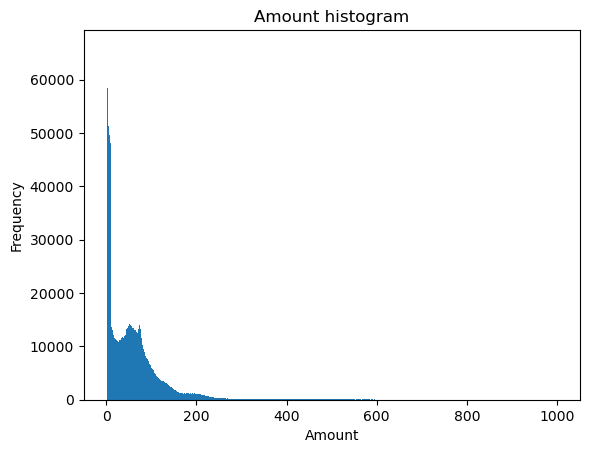

In [30]:
plt.hist(data['amt'], bins=1000, range=(0, 1000))
plt.title('Amount histogram')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()



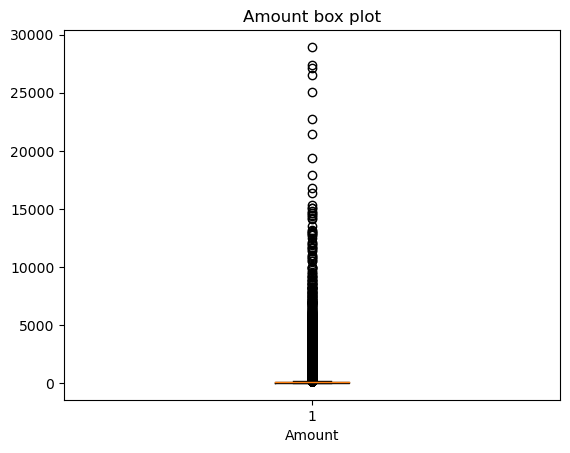

In [31]:
plt.boxplot(data['amt'])
plt.title('Amount box plot')
plt.xlabel('Amount')
plt.show()


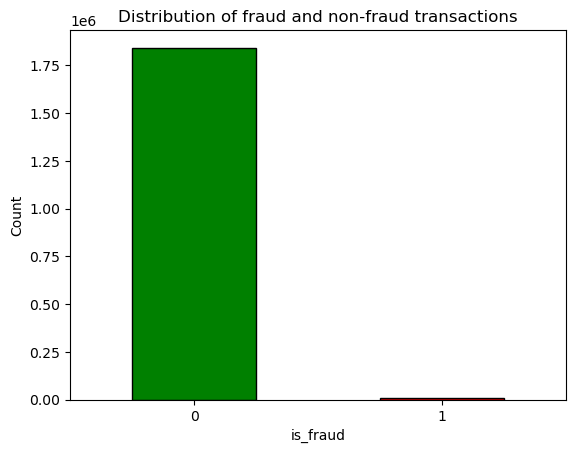

In [32]:

# Count the number of fraud and non-fraud transactions
counts = data['is_fraud'].value_counts()

# Create a bar plot of the counts
plt.bar(counts.index, counts.values, width=0.5, edgecolor='black', color=['green', 'red'])

# Add labels and title
plt.title('Distribution of fraud and non-fraud transactions')
plt.xlabel('is_fraud')
plt.ylabel('Count')

# Set the x-axis ticks and limits
plt.xticks([0, 1])
plt.xlim(-0.5, 1.5)

# Show the plot
plt.show()


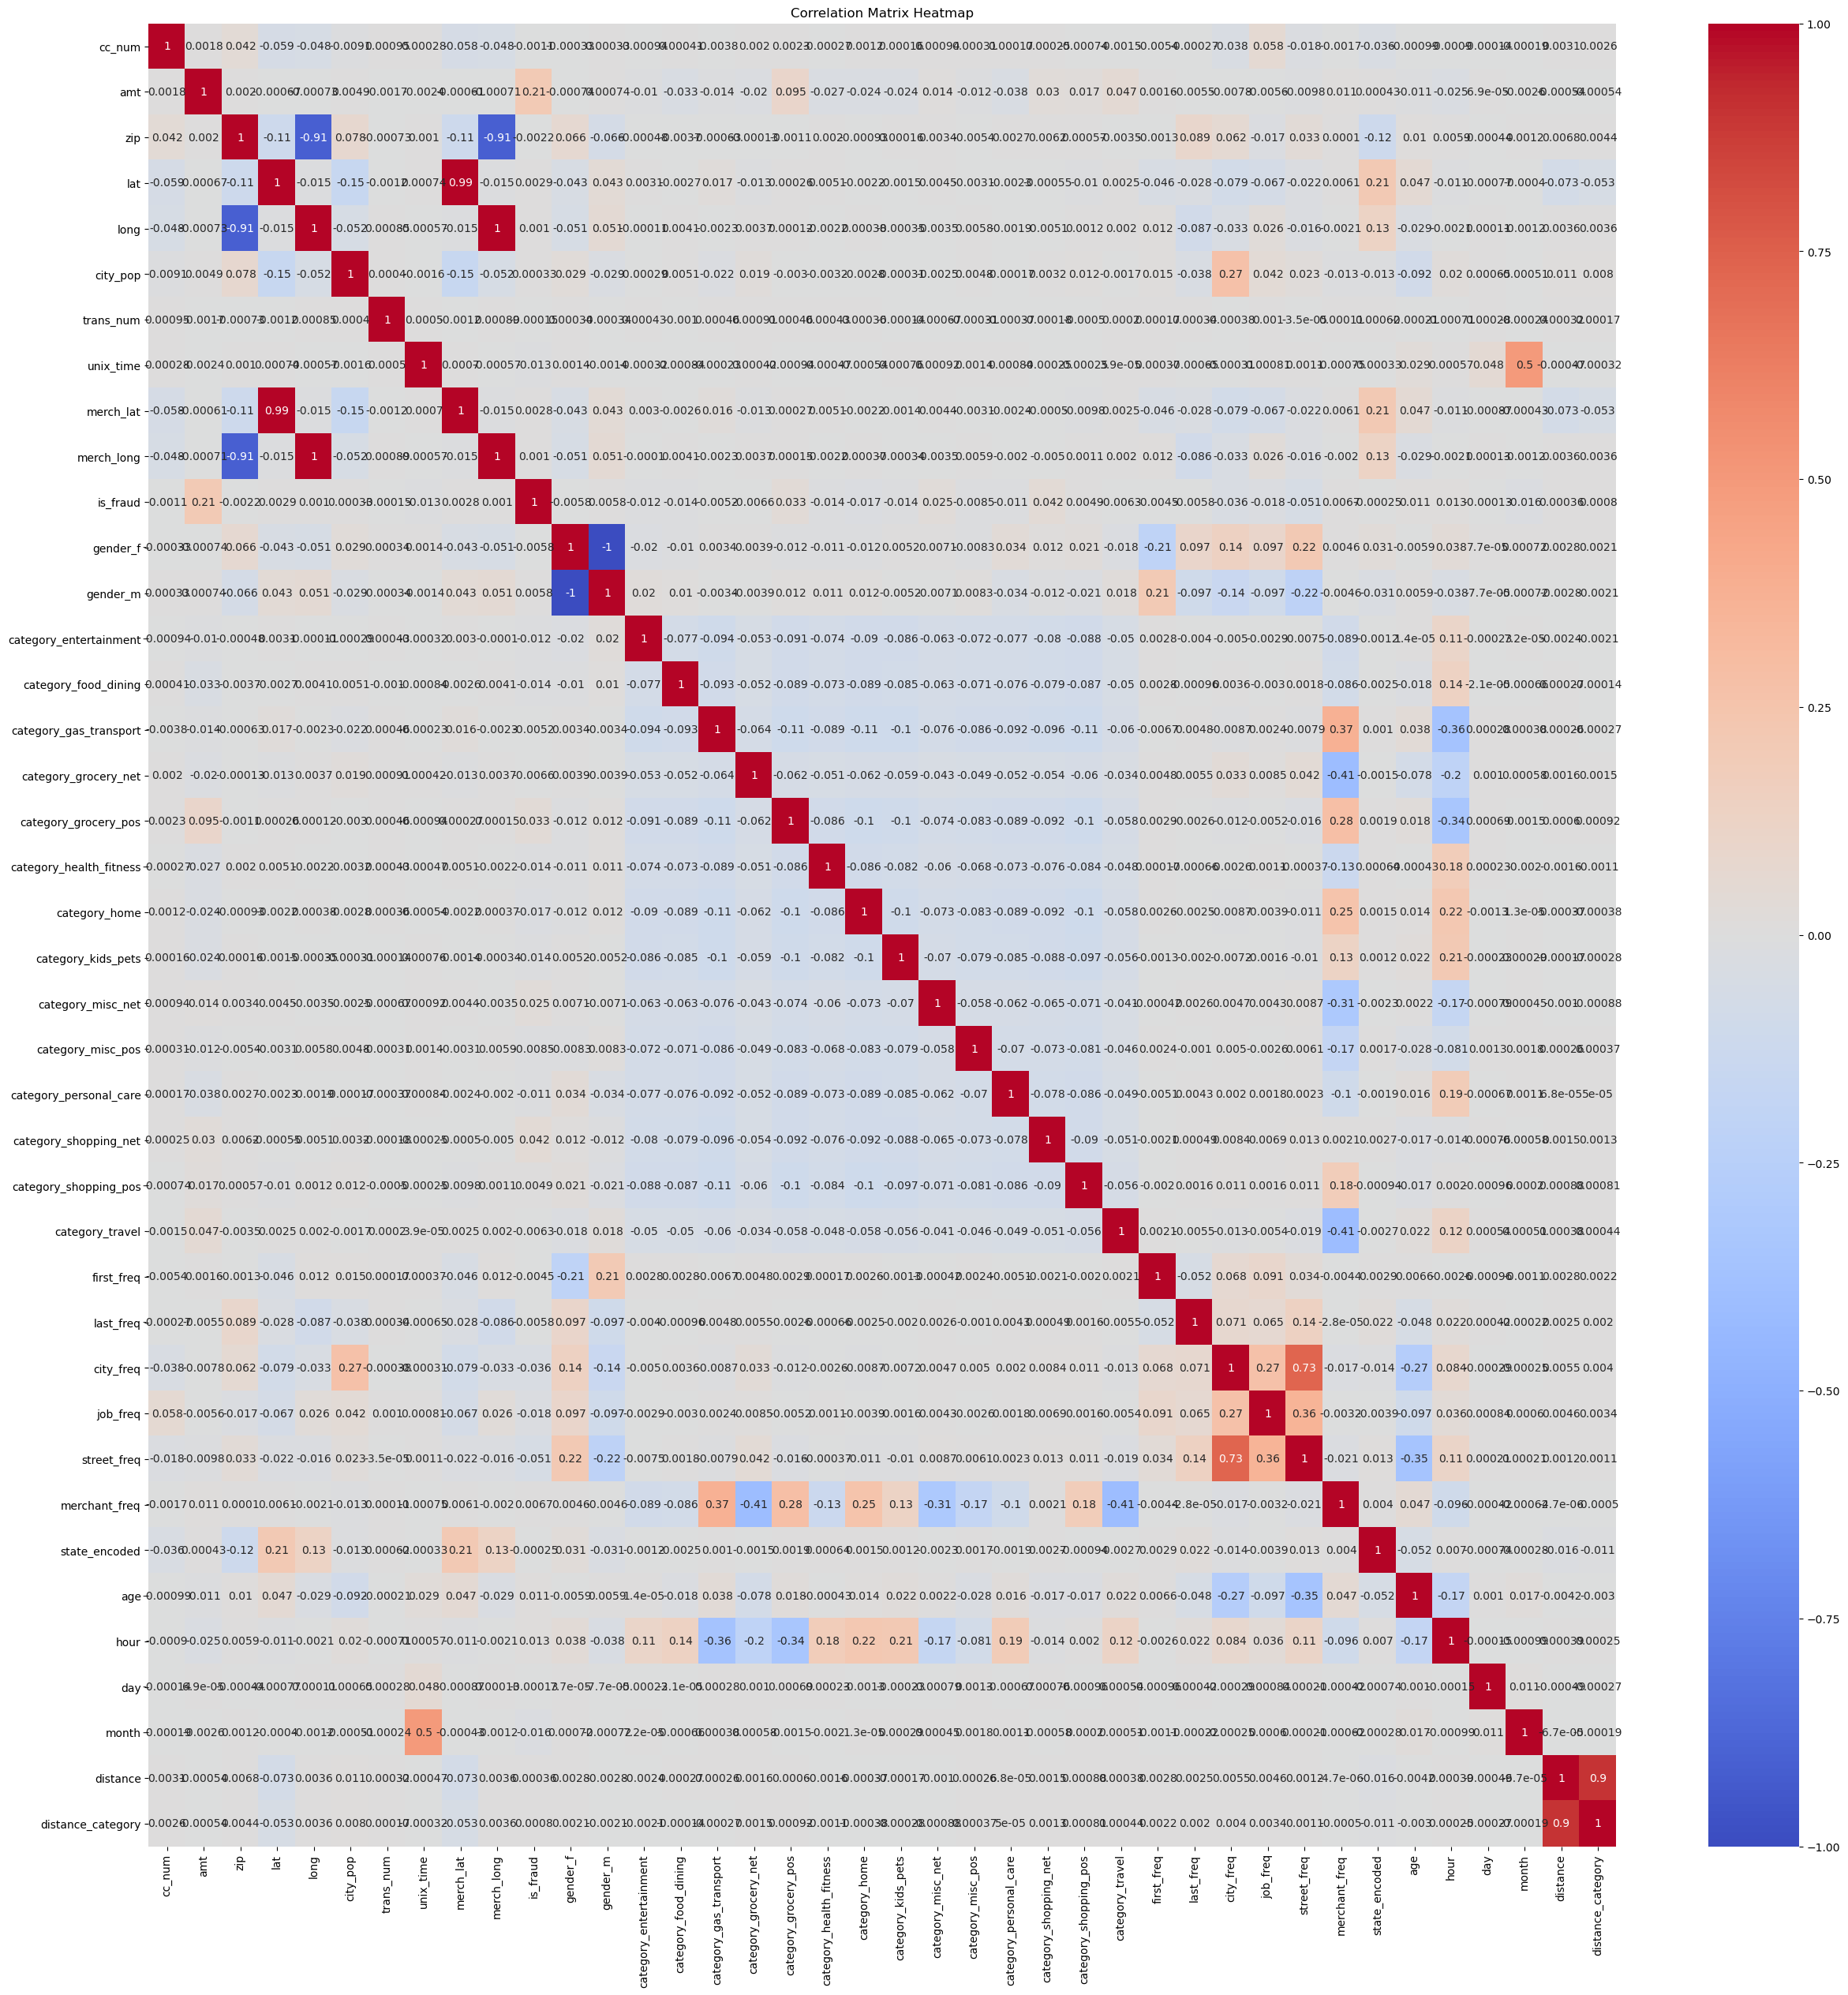

In [33]:
# Compute the correlation matrix
corr = data.corr()
plt.figure(figsize=(30,30))

# Create a heatmap of the correlation matrix
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)

# Add title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

In [34]:
cols = ['merchant', 'first', 'last', 'street', 'city', 'distance', 'lat', 'long', 'state', 'job', 'unix_time', 'trans_num']


data = data.drop(cols, axis=1)


In [35]:
print (data.columns)

Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'is_fraud', 'split_label', 'gender_f', 'gender_m',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'first_freq', 'last_freq',
       'city_freq', 'job_freq', 'street_freq', 'merchant_freq',
       'state_encoded', 'age', 'hour', 'day', 'month', 'distance_category'],
      dtype='object')


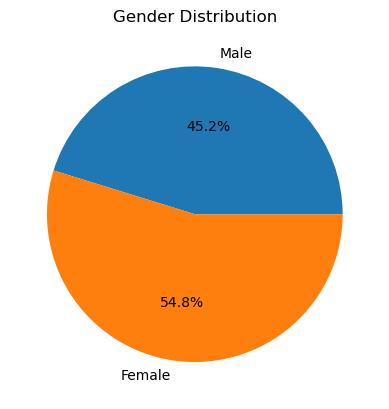

In [36]:
# Count the number of males and females
gender_counts = data[['gender_m', 'gender_f']].sum()

# Plot a pie chart of the gender distribution
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

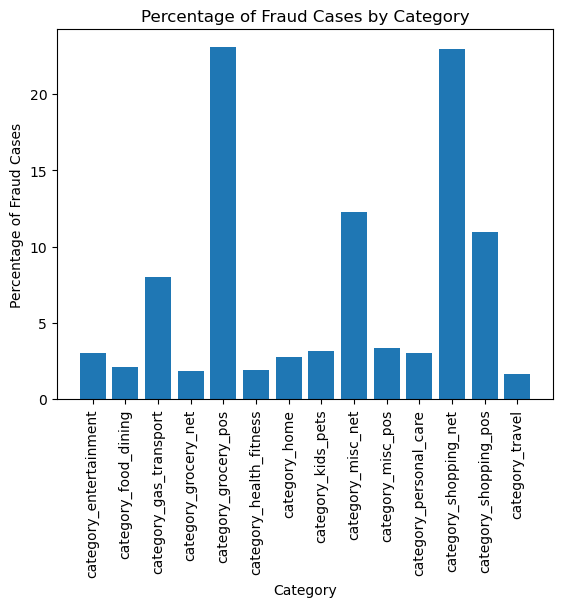

In [37]:
# Get the columns starting with 'Category_'
cat_cols = [col for col in data.columns if col.startswith('category_')]

# Compute the percentage of fraud cases for each category column
fraud_pct = []
for col in cat_cols:
    col_fraud = data.loc[(data[col] == 1) & (data['is_fraud'] == 1), 'is_fraud']
    if len(col_fraud) > 0:
        col_pct = 100 * len(col_fraud) / len(data.loc[data['is_fraud'] == 1, 'is_fraud'])
    else:
        col_pct = 0
    fraud_pct.append(col_pct)

# Create a barplot of the fraud percentages
plt.bar(cat_cols, fraud_pct)
plt.title('Percentage of Fraud Cases by Category')
plt.xlabel('Category')
plt.ylabel('Percentage of Fraud Cases')
plt.xticks(rotation=90)

In [38]:
# Loop through each column and check the data type
for col in data.columns:
    if not pd.api.types.is_numeric_dtype(data[col]):
        print(col, "is not numeric")

split_label is not numeric


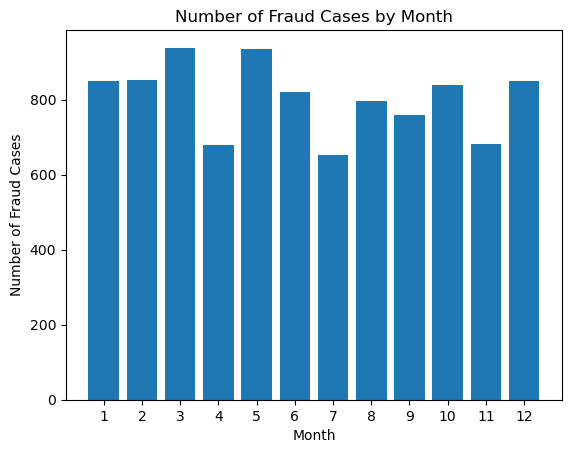

In [371]:
# Compute the total number of fraud cases for each month
fraud_cases_by_month = data.loc[data['is_fraud'] == 1, 'month'].value_counts().sort_index()

# Create a barplot of the fraud cases by month
plt.bar(fraud_cases_by_month.index, fraud_cases_by_month.values)
plt.title('Number of Fraud Cases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Fraud Cases')
plt.xticks(fraud_cases_by_month.index)
plt.show()

#FRAUD CLASSIFIER >> Random Forest

*we use the preprocessed data from above to start building our fraud detection model* 

first we have to split our data back into train and test set. The original dataset was already and then immeadieatley drop the split label from both dataframes 

In [39]:
train_data = data[data['split_label'] == 'train']
test_data = data[data['split_label'] == 'test']

# Drop the 'split_label' column from both data frames
train_data = train_data.drop('split_label', axis=1)
test_data = test_data.drop('split_label', axis=1)

In [40]:
print(train_data.dtypes)


cc_num                       int64
amt                        float64
zip                          int64
city_pop                     int64
merch_lat                  float64
merch_long                 float64
is_fraud                     int64
gender_f                     uint8
gender_m                     uint8
category_entertainment       uint8
category_food_dining         uint8
category_gas_transport       uint8
category_grocery_net         uint8
category_grocery_pos         uint8
category_health_fitness      uint8
category_home                uint8
category_kids_pets           uint8
category_misc_net            uint8
category_misc_pos            uint8
category_personal_care       uint8
category_shopping_net        uint8
category_shopping_pos        uint8
category_travel              uint8
first_freq                 float64
last_freq                  float64
city_freq                  float64
job_freq                   float64
street_freq                float64
merchant_freq       

In [40]:
# Print the column names of the training data
print("Training data columns:")
print(data.columns)

# Print the column names of the test data
print("Test data columns:")
print(test_data.columns)

print("Original data columns:")
print(data_copy.columns)


Training data columns:
Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'is_fraud', 'split_label', 'gender_f', 'gender_m',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'first_freq', 'last_freq',
       'city_freq', 'job_freq', 'street_freq', 'merchant_freq',
       'state_encoded', 'age', 'hour', 'day', 'month', 'distance_category'],
      dtype='object')
Test data columns:
Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'is_fraud', 'gender_f', 'gender_m', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_hea

In [ ]:
# Extract the input features and target variable for the training set
X_train = train_data.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Define the range of values for n_estimators
n_estimators_range = range(1, 501, 50)

# Train and test the Random Forest model with different values of n_estimators
for n_estimators in n_estimators_range:
    # Train the model with the current value of n_estimators
    rf = RandomForestClassifier(n_estimators=n_estimators, warm_start=True, random_state=42)
    rf.fit(X_train_balanced, y_train_balanced)
    
    # Test the model on the test set
    X_test = test_data.drop(['is_fraud', 'error_label'], axis=1)
    y_test = test_data['is_fraud']
    y_pred = rf.predict(X_test)
    
    # Print the performance metrics for the current iteration
    print(f"n_estimators = {n_estimators}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [ ]:
# Define the range of values for n_estimators
n_estimators_range = range(50, 501, 50)

# Initialize empty lists to store the evaluation metrics
fpr_list = []
tpr_list = []
tnr_list= []
fnr_list = []
roc_auc_list = []

# Train and test the Random Forest model with different values of n_estimators
for n_estimators in n_estimators_range:
    # Train the model with the current value of n_estimators
    rf = RandomForestClassifier(n_estimators=n_estimators, warm_start=True, random_state=42)
    rf.fit(X_train_balanced, y_train_balanced)#smote has already been applied in the field above so the X_train_balanced and y_train_balanced were already defined
    
    # Test the model on the test set
    X_test = test_data.drop(['is_fraud', 'error_label'], axis=1)
    y_test = test_data['is_fraud']
    y_pred_prob = rf.predict_proba(X_test)[:, 1]  # Predict probabilities of the positive class
    
    # Calculate evaluation metrics
    y_pred = rf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Append the metrics to the respective lists
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    tnr_list.append(tnr)
    fnr_list.append(fnr)
    roc_auc_list.append(roc_auc)
    
    # Print the performance metrics for the current iteration
    print(f"n_estimators = {n_estimators}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("False Positive Rate: {:.2f}%".format(fpr * 100))
    print("True Negative Rate: {:.2f}%".format(tnr * 100))
    print("False Negative Rate: {:.2f}%".format(fnr * 100))
    print("True Positive Rate: {:.2f}%".format(tpr * 100))
    print("ROC AUC Score: {:.4f}".format(roc_auc))
    print("-" * 50)


In [ ]:
# Define the probability thresholds
prob_thresholds = np.arange(0, 1.05, 0.05)

# Initialize empty lists to store the evaluation metrics
fpr_list_350 = []
tpr_list_350 = []
tnr_list_350 = []
fnr_list_350 = []
roc_auc_list_350 = []

# Train and test the Random Forest model with n_estimators=350 and different probability thresholds
rf_350 = RandomForestClassifier(n_estimators=350, max_depth=10, warm_start=True, random_state=42, n_jobs=-1)
rf_350.fit(X_train_balanced, y_train_balanced)

for prob_threshold in prob_thresholds:
    # Test the model on the test set with the current probability threshold
    y_pred_prob = rf_350.predict_proba(X_test)[:, 1]  # Predict probabilities of the positive class
    y_pred = (y_pred_prob > prob_threshold).astype(int)
    
    # Calculate evaluation metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    # Append the metrics to the respective lists
    fpr_list_350.append(fpr)
    tpr_list_350.append(tpr)
    tnr_list_350.append(tnr)
    fnr_list_350.append(fnr)
    roc_auc_list_350.append(roc_auc)
    
    # Print the performance metrics for the current iteration
    print(f"Probability threshold = {prob_threshold}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("False Positive Rate: {:.2f}%".format(fpr * 100))
    print("True Negative Rate: {:.2f}%".format(tnr * 100))
    print("False Negative Rate: {:.2f}%".format(fnr * 100))
    print("True Positive Rate: {:.2f}%".format(tpr * 100))
    print("ROC AUC Score: {:.4f}".format(roc_auc))
    print("-" * 50)


In [ ]:
# Define the max depths to experiment with
max_depths = range(1, 21)

# Define the probability threshold to use
prob_threshold = 0.5

# Initialize empty lists to store the evaluation metrics
fpr_md_list = []
tpr_md_list = []
tnr_md_list = []
fnr_md_list = []
roc_auc_md_list = []

# Loop over values of max_depth from 1 to 20
for max_depth in max_depths:
    # Train and test the Random Forest model with n_estimators=350, max_depth=max_depth, and probability threshold=prob_threshold
    rf_md = RandomForestClassifier(n_estimators=350, max_depth=max_depth, warm_start=True, random_state=42, n_jobs=-1)
    rf_md.fit(X_train_balanced, y_train_balanced)

    # Test the model on the test set with the current probability threshold
    y_pred_prob_md = rf_md.predict_proba(X_test)[:, 1]  # Predict probabilities of the positive class
    y_pred_md = (y_pred_prob_md > prob_threshold).astype(int)

    # Calculate evaluation metrics
    tn_md, fp_md, fn_md, tp_md = confusion_matrix(y_test, y_pred_md).ravel()
    fpr_md = fp_md / (fp_md + tn_md)
    tnr_md = tn_md / (tn_md + fp_md)
    fnr_md = fn_md / (fn_md + tp_md)
    tpr_md = tp_md / (tp_md + fn_md)
    roc_auc_md = roc_auc_score(y_test, y_pred_prob_md)

    # Append the metrics to the respective lists
    fpr_md_list.append(fpr_md)
    tpr_md_list.append(tpr_md)
    tnr_md_list.append(tnr_md)
    fnr_md_list.append(fnr_md)
    roc_auc_md_list.append(roc_auc_md)

    # Print the performance metrics for the current value of max_depth
    print(f"max_depth = {max_depth}")
    print(confusion_matrix(y_test, y_pred_md))
    print(classification_report(y_test, y_pred_md))
    print("False Positive Rate: {:.2f}%".format(fpr_md * 100))
    print("True Negative Rate: {:.2f}%".format(tnr_md * 100))
    print("False Negative Rate: {:.2f}%".format(fnr_md * 100))
    print("True Positive Rate: {:.2f}%".format(tpr_md * 100))
    print("ROC AUC Score: {:.4f}".format(roc_auc_md))
    print("-" * 50)


In [ ]:
# Extract the input features and target variable for the training set
X_train = train_data.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define the probability thresholds
prob_thresholds = np.arange(0, 1.05, 0.05)

# Initialize empty lists to store the evaluation metrics
fpr_list_th = []
tpr_list_th = []
tnr_list_th = []
fnr_list_th = []
roc_auc_list_th = []

# Train and test the Random Forest model with n_estimators=350 and different probability thresholds
rf_th = RandomForestClassifier(n_estimators=350, max_depth=14, warm_start=True, random_state=42, n_jobs=-1)
rf_th.fit(X_train_balanced, y_train_balanced)

for prob_threshold_th in prob_thresholds:
    # Test the model on the test set with the current probability threshold
    X_test = test_data.drop(['is_fraud'], axis=1)
    y_test = test_data['is_fraud']
    y_pred_prob_th = rf_th.predict_proba(X_test)[:, 1]  # Predict probabilities of the positive class
    y_pred_th = (y_pred_prob_th > prob_threshold_th).astype(int)
    
    # Calculate evaluation metrics
    tn_th, fp_th, fn_th, tp_th = confusion_matrix(y_test, y_pred_th).ravel()
    fpr_th = fp_th / (fp_th + tn_th)
    tnr_th = tn_th / (tn_th + fp_th)
    fnr_th = fn_th / (fn_th + tp_th)
    tpr_th = tp_th / (tp_th + fn_th)
    roc_auc_th = roc_auc_score(y_test, y_pred_prob_th)
    
    # Append the metrics to the respective lists
    fpr_list_th.append(fpr_th)
    tpr_list_th.append(tpr_th)
    tnr_list_th.append(tnr_th)
    fnr_list_th.append(fnr_th)
    roc_auc_list_th.append(roc_auc_th)
    
    # Print the performance metrics for the current iteration
    print(f"Probability threshold = {prob_threshold_th}")
    print(confusion_matrix(y_test, y_pred_th))
    print(classification_report(y_test, y_pred_th))
    print("False Positive Rate: {:.2f}%".format(fpr_th * 100))
    print("True Negative Rate: {:.2f}%".format(tnr_th * 100))
    print("False Negative Rate: {:.2f}%".format(fnr_th * 100))
    print("True Positive Rate: {:.2f}%".format(tpr_th * 100))
    print("ROC AUC Score: {:.4f}".format(roc_auc_th))
    print("-" * 50)


In [ ]:
# number of newly generated samples
n_new_samples = len(X_train_balanced) - len(X_train)
print(f"Number of new samples generated by SMOTE: {n_new_samples}")

Number of new samples generated by SMOTE: 1281663


In [41]:
# Extract the input features and target variable for the training set
X_train = train_data.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train the Random Forest model with n_estimators=350
rf_final = RandomForestClassifier(n_estimators=350, max_depth=14, random_state=42)
rf_final.fit(X_train_balanced, y_train_balanced)

# Test the model on the test set
X_test = test_data.drop(['is_fraud'], axis=1)
y_test = test_data['is_fraud']
y_pred_prob = rf_final.predict_proba(X_test)[:, 1]  # Predict probabilities of the positive class
y_pred = (y_pred_prob > 0.3).astype(int)  # Set probability threshold to 0.3

# Calculate evaluation metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the performance metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("False Positive Rate: {:.2f}%".format(fpr * 100))
print("True Negative Rate: {:.2f}%".format(tnr * 100))
print("False Negative Rate: {:.2f}%".format(fnr * 100))
print("True Positive Rate: {:.2f}%".format(tpr * 100))
print("ROC AUC Score: {:.4f}".format(roc_auc))


[[536074  17500]
 [   241   1904]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.10      0.89      0.18      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.93      0.58    555719
weighted avg       1.00      0.97      0.98    555719

False Positive Rate: 3.16%
True Negative Rate: 96.84%
False Negative Rate: 11.24%
True Positive Rate: 88.76%
ROC AUC Score: 0.9781


In [42]:
# Initialize the error labels to -1 (uninitialized)
test_data['error_label'] = -1

# Assign error labels based on the true/false positive/negative status
test_data.loc[(test_data['is_fraud'] == 0) & (y_pred == 1), 'error_label'] = 0  # False positive
test_data.loc[(test_data['is_fraud'] == 1) & (y_pred == 1), 'error_label'] = 1  # True positive
test_data.loc[(test_data['is_fraud'] == 0) & (y_pred == 0), 'error_label'] = 2  # True negative
test_data.loc[(test_data['is_fraud'] == 1) & (y_pred == 0), 'error_label'] = 3  # False negative


# Create a new DataFrame with the predicted values
predictions_df = pd.DataFrame({'is_fraud_predicted': y_pred})

# Merge the predicted values with the original testing set
test_results_data = test_data.merge(predictions_df, left_index=True, right_index=True)

In [43]:
print(test_data['error_label'].unique())
print((test_data['error_label'] == 0).sum())



[2 0 3 1]
17500


In [44]:
print(X_train.columns)
print(X_test.columns)
print(test_data.columns)
print(test_results_data.columns)

Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'gender_f', 'gender_m', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'first_freq', 'last_freq', 'city_freq', 'job_freq', 'street_freq',
       'merchant_freq', 'state_encoded', 'age', 'hour', 'day', 'month',
       'distance_category'],
      dtype='object')
Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'gender_f', 'gender_m', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 

# BUILDING CLUSTERS

First we have to add an extra column to the dataframe which includes the error labels. In the beginning we made a copy of our test data so we can compare the predicted results with the actual results

In [49]:
# Check for non-numeric values
non_numeric_cols = X_test.select_dtypes(exclude='number').columns.tolist()
print(non_numeric_cols)


[]


# We create a df to work with for K-means and for DBSCAN, that solely contains the fasle positive instances, so we have to filter on "error_label" =0 
>> KMEANS = km_fp 
>> DBSCAN = db_fp

In [115]:
km_fp = test_data[test_data['error_label'] == 0]

In [ ]:
db_fp = test_data[test_data['error_label'] == 0]

In [52]:
print(db_fp.columns)
print(km_fp.columns)

Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'is_fraud', 'gender_f', 'gender_m', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'first_freq', 'last_freq', 'city_freq', 'job_freq', 'street_freq',
       'merchant_freq', 'state_encoded', 'age', 'hour', 'day', 'month',
       'distance_category', 'error_label'],
      dtype='object')
Index(['cc_num', 'amt', 'zip', 'city_pop', 'merch_lat', 'merch_long',
       'is_fraud', 'gender_f', 'gender_m', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_k

om te beginnen, features van clustering hetzelfde houden als van classifier omdat het dan 1 op is.



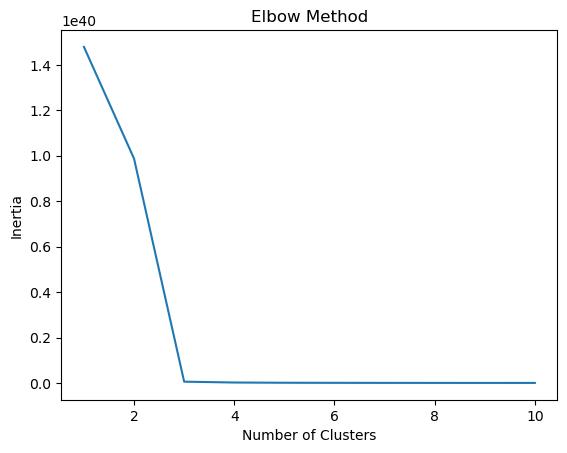

In [74]:
elbow = km_fp

# Fit KMeans with a range of cluster numbers
inertias = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(elbow)
    inertias.append(kmeans.inertia_)

# Apply rolling average to smooth the inertia values
window_size = 3  # Adjust the window size as desired
smoothed_inertias = pd.Series(inertias).rolling(window_size, min_periods=1, center=True).mean()

# Plot the smoothed results
plt.plot(range(1, 11), smoothed_inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


Weight: 0.0


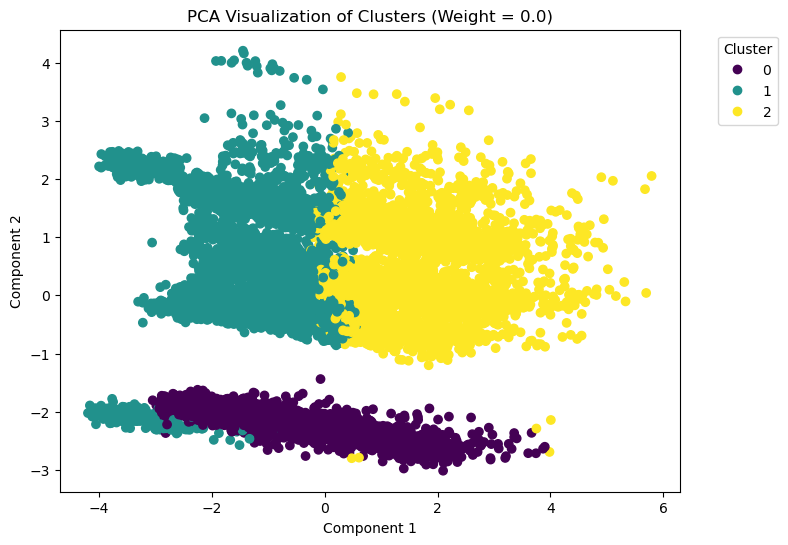

Silhouette Score: 0.0599919256999632
Weight: 0.5


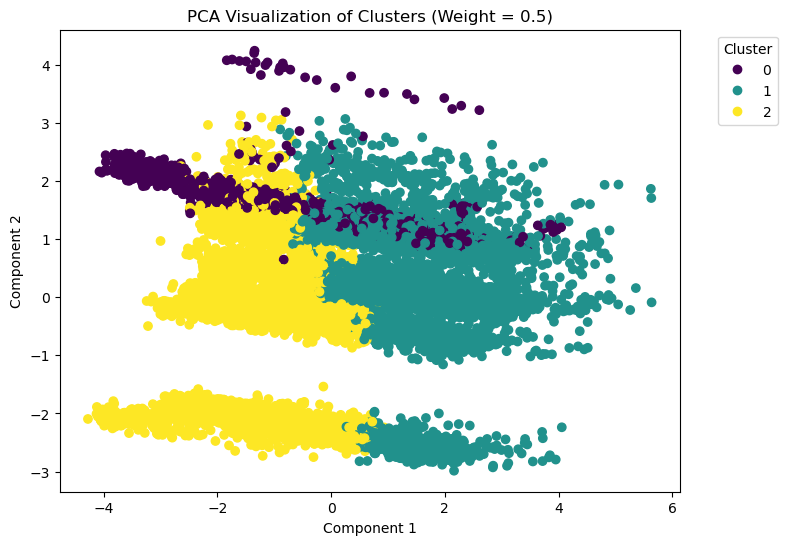

Silhouette Score: 0.07084015591736637
Weight: 1.0


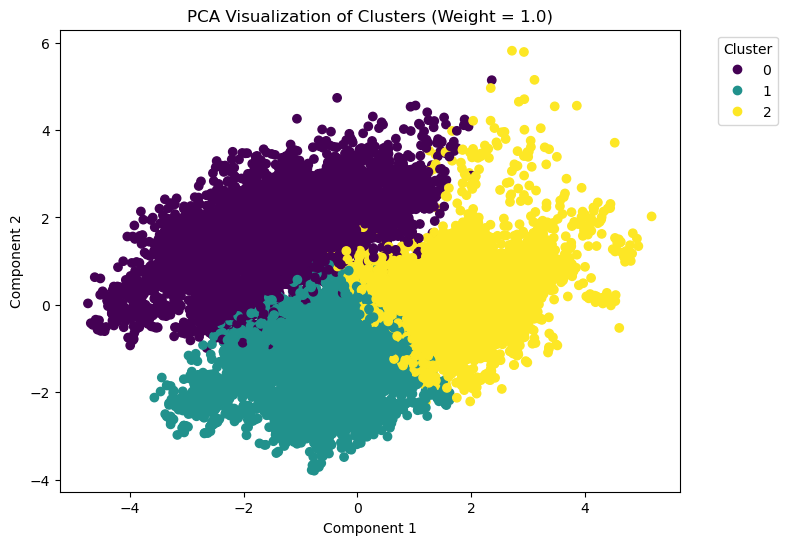

Silhouette Score: 0.061925328926797675
Weight: 1.5


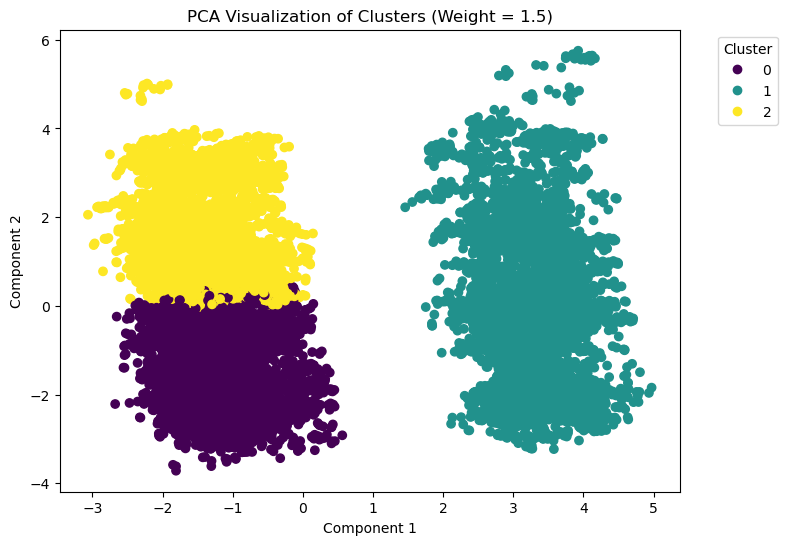

Silhouette Score: 0.0897838493069799
Weight: 2.0


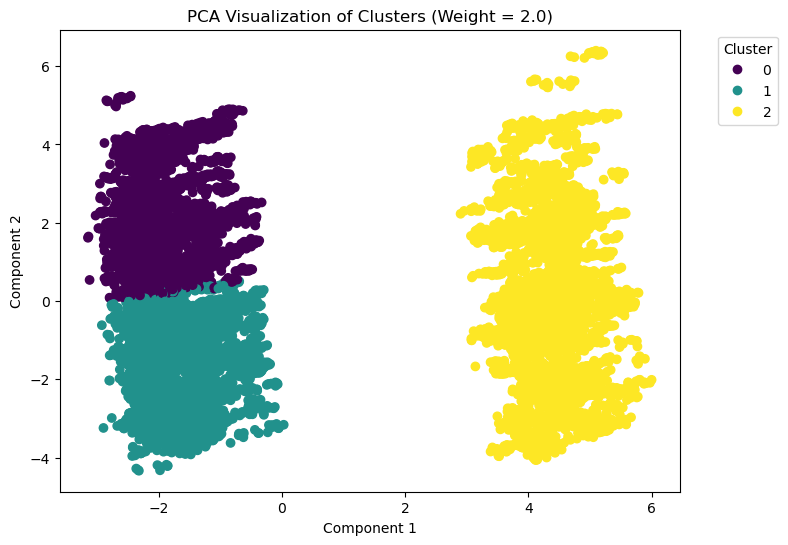

Silhouette Score: 0.12540604668201422
Weight: 2.5


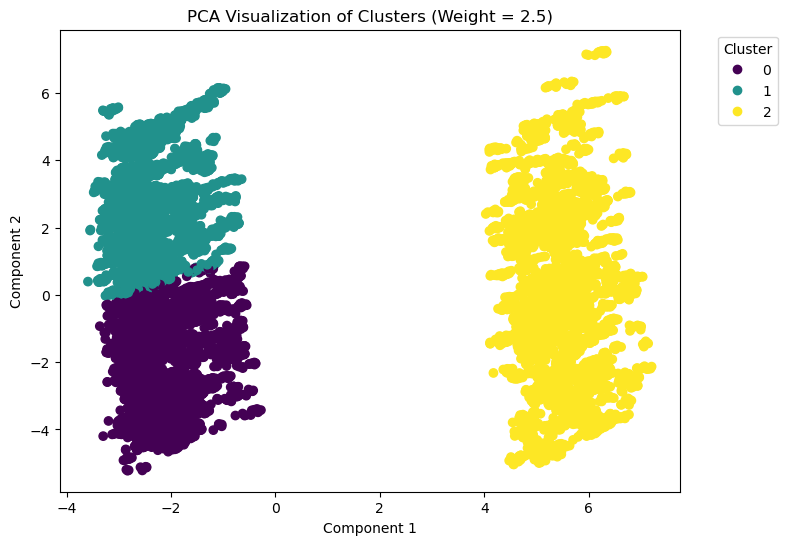

Silhouette Score: 0.1588699740159056
Weight: 3.0


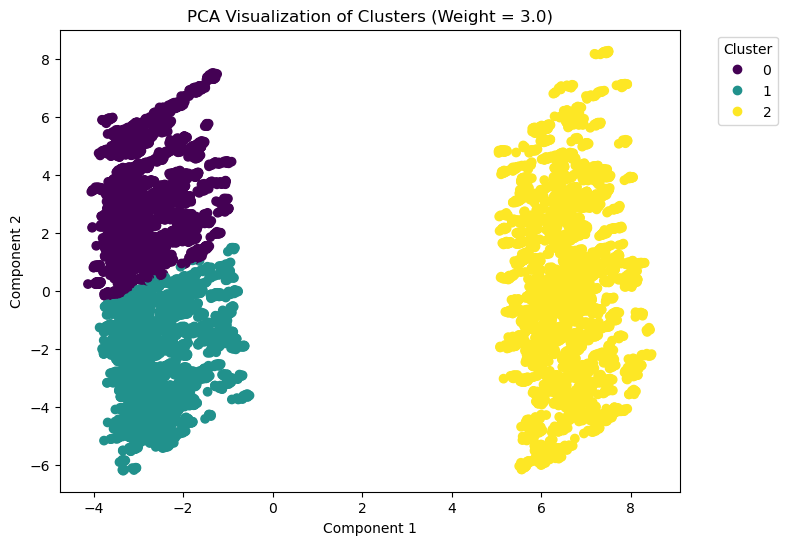

Silhouette Score: 0.1889918162314237
Weight: 3.5


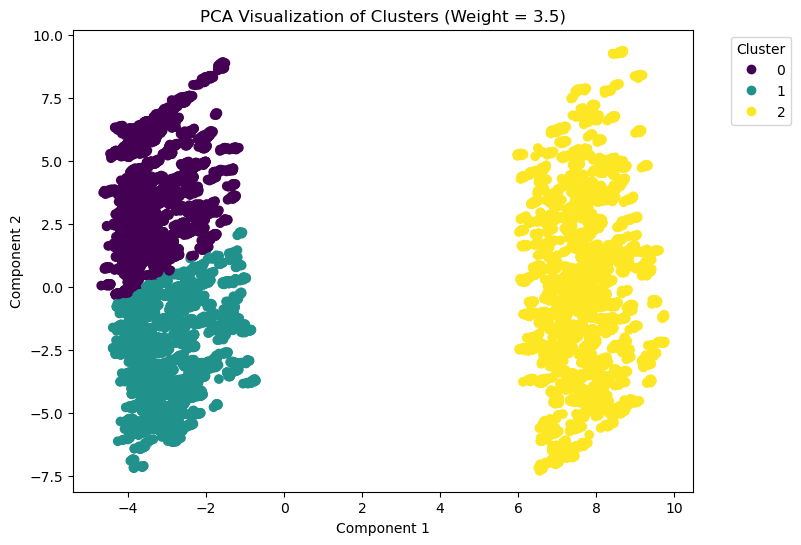

Silhouette Score: 0.21542206738888506
Weight: 4.0


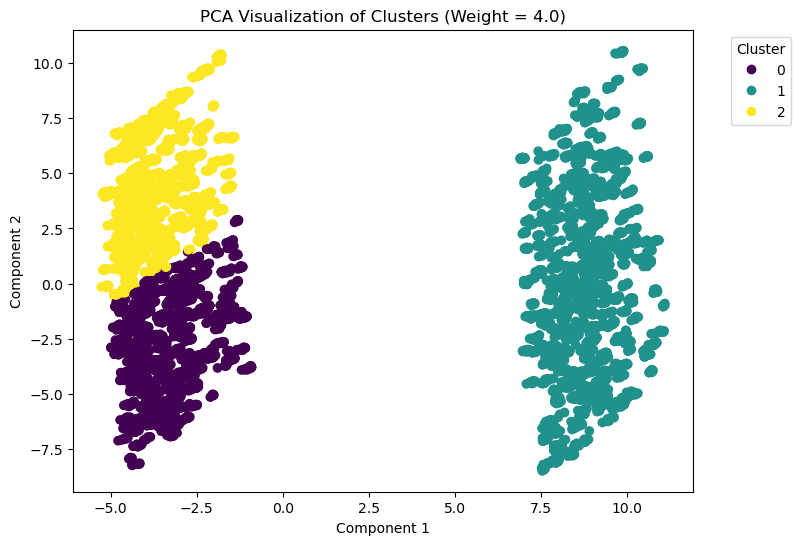

Silhouette Score: 0.23835879909039492
Weight: 4.5


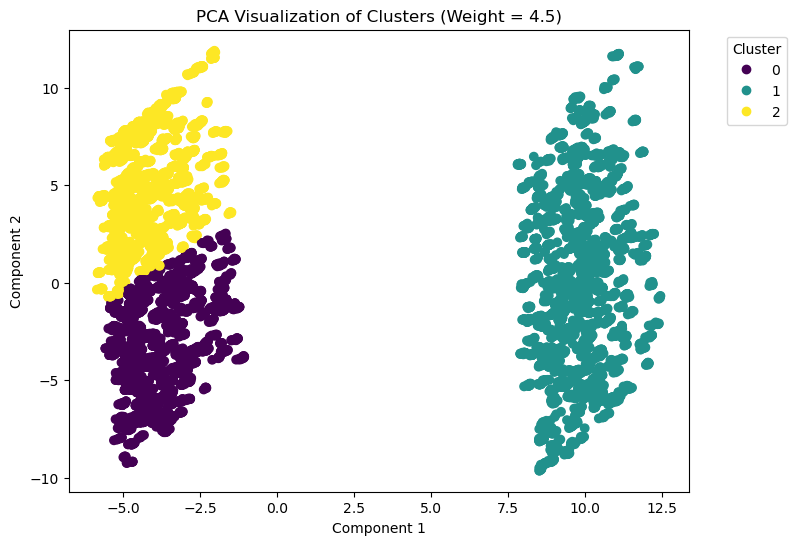

Silhouette Score: 0.25832099934630864
Weight: 5.0


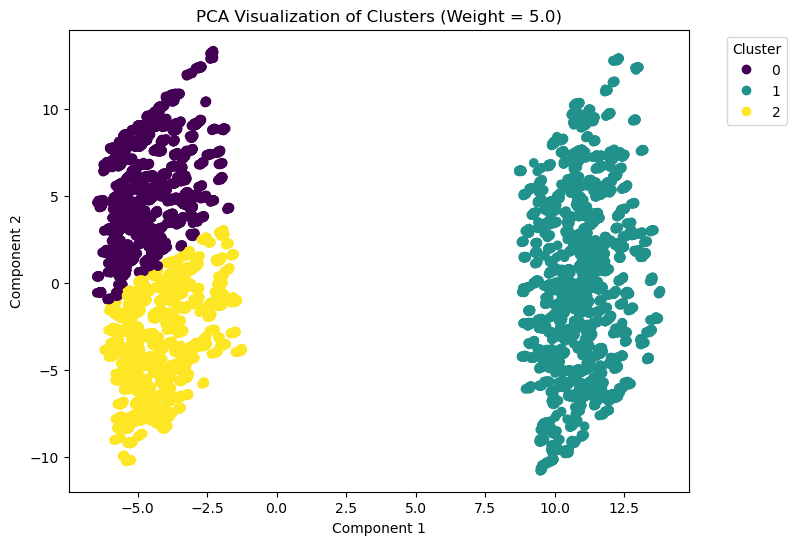

Silhouette Score: 0.27546452067284316
Weight: 6.0


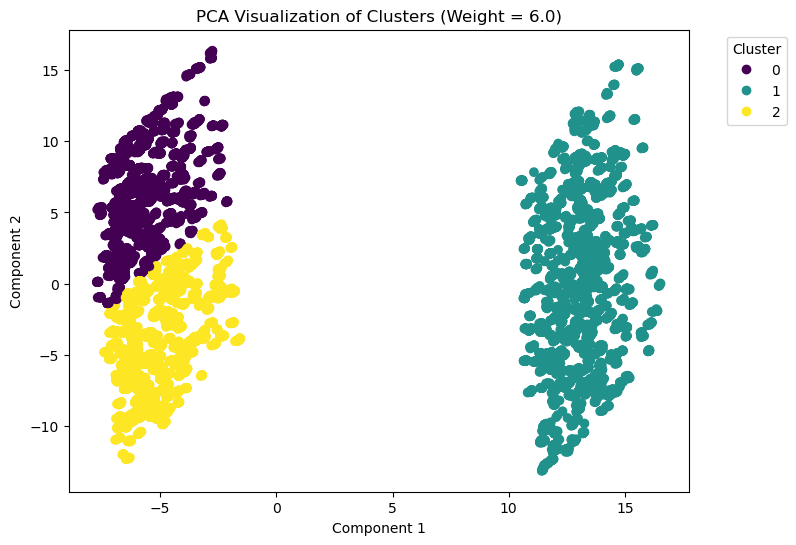

Silhouette Score: 0.30322849623214504
Weight: 7.0


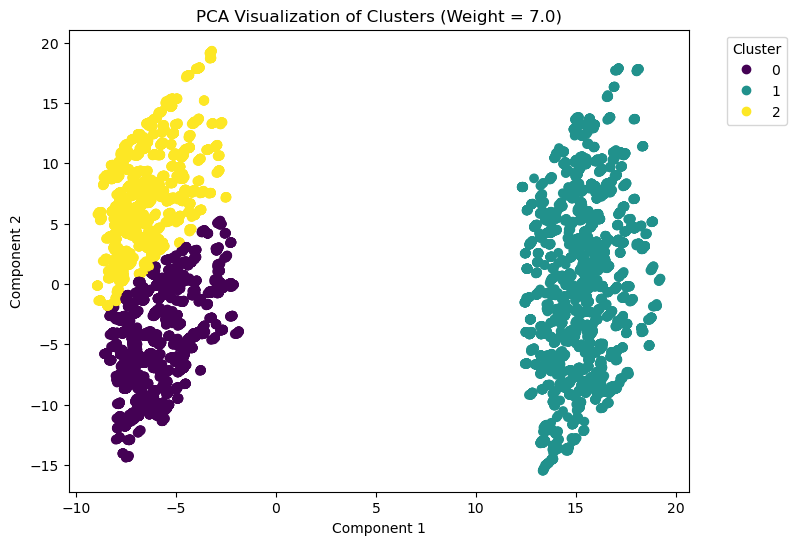

Silhouette Score: 0.3242301385129743
Weight: 8.0


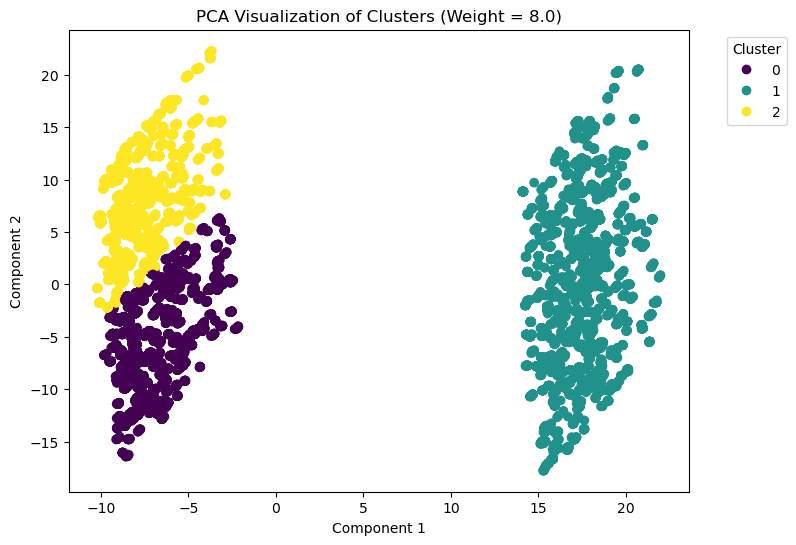

Silhouette Score: 0.33997568199658257
Weight: 9.0


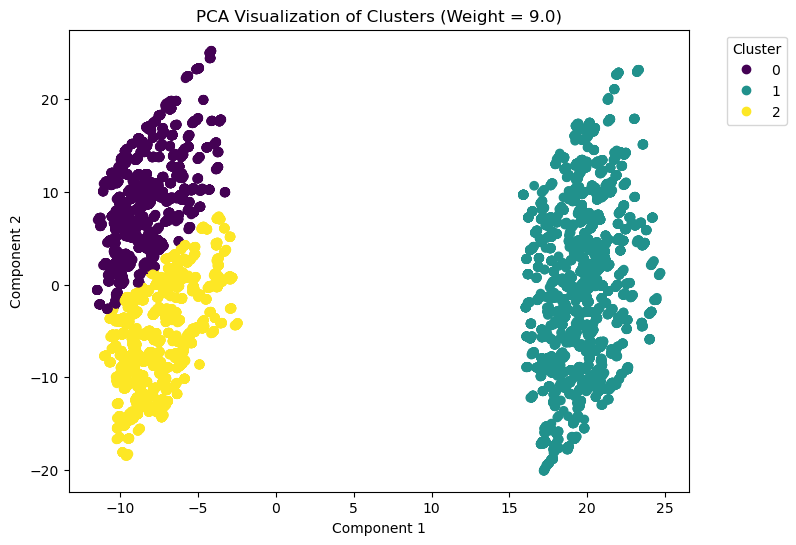

Silhouette Score: 0.35267084127327186
Weight: 10.0


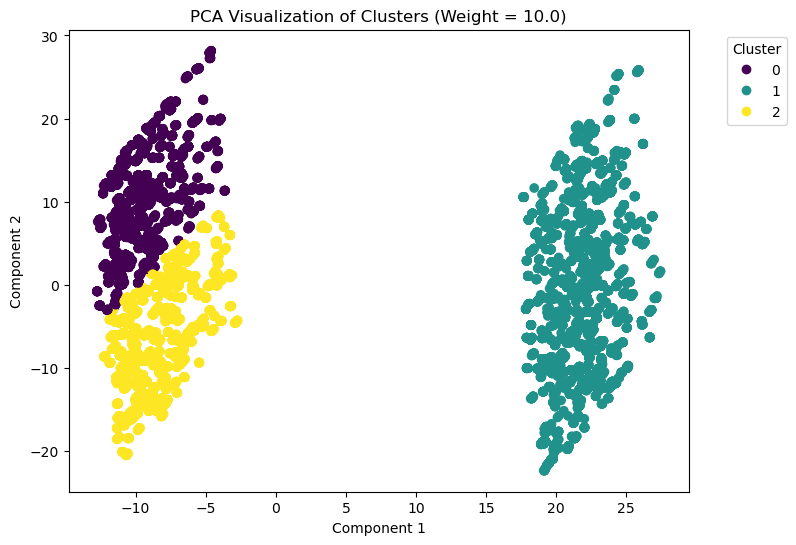

Silhouette Score: 0.36276899337774393


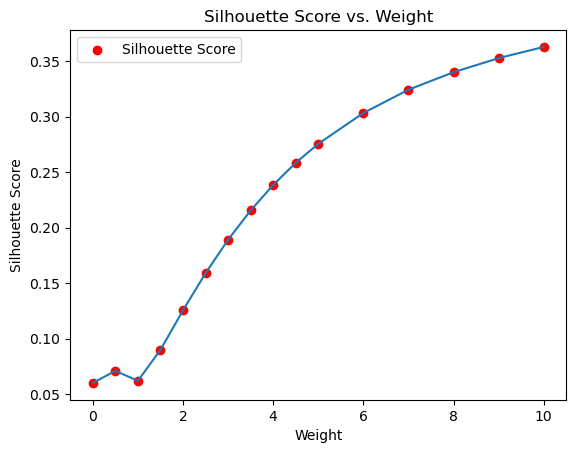

In [120]:

#############################
#####FINAL KMEANS MODEL #####
#############################

#WE USE K=3 AS DETERMINED BY THE ELBOW METHOD
# Define the sensitive features to use for clustering
sensitive_features = ['zip', 'gender_m', 'gender_f', 'age']

# Scale all features using StandardScaler
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(km_fp)

# Get the indices of sensitive features
sensitive_features_indices = [km_fp.columns.get_loc(feature) for feature in sensitive_features]

# Define the weight range
weight_range = np.concatenate([np.arange(0.0, 5.5, 0.5), np.arange(6, 11, 1)])

# Iterate over weight values
silhouette_scores_km = []  # List to store silhouette scores

for weight_factor in weight_range:
    print(f'Weight: {weight_factor}')  # Print the weight factor

    # Create a copy of the scaled features
    kmeans_weighted = kmeans_scaled.copy()

    # Apply the weight factor to the sensitive features
    kmeans_weighted[:, sensitive_features_indices] *= weight_factor


    # Perform K-Means clustering on the scaled data
    kmeans = KMeans(n_clusters=3, random_state=42).fit(kmeans_weighted)

    # Perform PCA to reduce the number of dimensions to 2 for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(kmeans_weighted)

    #  Plot the clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.predict(kmeans_weighted))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'PCA Visualization of Clusters (Weight = {weight_factor})')

    # Adjust the legend position to be outside the plot area    
    plt.legend(*scatter.legend_elements(), title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

    
    # Compute silhouette score
    silhouette_km = silhouette_score(kmeans_weighted, kmeans.labels_)
    silhouette_scores_km.append(silhouette_km)
    print(f'Silhouette Score: {silhouette_km}')

# Plot the silhouette scores
plt.plot(weight_range, silhouette_scores_km)
plt.scatter(weight_range, silhouette_scores_km, color='red', label='Silhouette Score')
plt.xlabel('Weight')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Weight')
plt.legend()
plt.show()


In [138]:
# Define the sensitive features to use for clustering
sensitive_features = ['zip', 'gender_m', 'gender_f', 'age']

# Scale all features using StandardScaler
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(km_fp)

# Get the indices of sensitive features
sensitive_features_indices = [km_fp.columns.get_loc(feature) for feature in sensitive_features]

# Define the weight range
weight_range = np.concatenate([np.arange(0.0, 5.5, 0.5), np.arange(6, 11, 1)])

# Iterate over weight values
important_features = {}  # Dictionary to store important features

for weight_factor in weight_range:
    # Create a copy of the scaled features
    kmeans_weighted = kmeans_scaled.copy()

    # Apply the weight factor to the sensitive features
    kmeans_weighted[:, sensitive_features_indices] *= weight_factor

    # Perform K-Means clustering on the weighted data
    kmeans = KMeans(n_clusters=3, random_state=42).fit(kmeans_weighted)

    # Calculate feature scores
    feature_scores = np.abs(kmeans.cluster_centers_ * weight_factor)

    # Get the indices of the top N features for each cluster
    num_top_features = 5  # Number of top features to consider
    top_features_indices = np.argsort(feature_scores, axis=1)[:, -num_top_features:][:, ::-1]

    # Get the names of the top features
    top_features_names = [km_fp.columns[indices] for indices in top_features_indices]

    # Store the top features for each cluster at each weight
    important_features[weight_factor] = top_features_names

# Print the important features for each weight and cluster
for weight_factor, cluster_features in important_features.items():
    print(f"Weight: {weight_factor}")
    for cluster, features in enumerate(cluster_features):
        print(f"Cluster {cluster}: {features}")
    print()


Weight: 0.0
Cluster 0: Index(['error_label', 'distance_category', 'category_home',
       'category_health_fitness', 'category_grocery_pos'],
      dtype='object')
Cluster 1: Index(['error_label', 'distance_category', 'category_home',
       'category_health_fitness', 'category_grocery_pos'],
      dtype='object')
Cluster 2: Index(['error_label', 'distance_category', 'category_home',
       'category_health_fitness', 'category_grocery_pos'],
      dtype='object')

Weight: 0.5
Cluster 0: Index(['category_grocery_pos', 'category_gas_transport', 'merchant_freq',
       'hour', 'category_shopping_net'],
      dtype='object')
Cluster 1: Index(['street_freq', 'city_freq', 'job_freq', 'amt', 'category_shopping_pos'], dtype='object')
Cluster 2: Index(['street_freq', 'city_freq', 'merchant_freq', 'job_freq',
       'category_grocery_pos'],
      dtype='object')

Weight: 1.0
Cluster 0: Index(['gender_f', 'gender_m', 'category_grocery_pos', 'first_freq', 'age'], dtype='object')
Cluster 1: Index([

In [220]:
# Iterate over weight values
important_features = {}  # Dictionary to store important features

for weight_factor in weight_range:
    print(f'Weight: {weight_factor}')  # Print the weight factor

    # Create a copy of the scaled features
    kmeans_weighted = kmeans_scaled.copy()

    # Apply the weight factor to the sensitive features
    kmeans_weighted[:, sensitive_features_indices] *= weight_factor

    # Perform K-Means clustering on the weighted data
    kmeans = KMeans(n_clusters=3, random_state=42).fit(kmeans_weighted)

    # Get the cluster labels for each sample
    cluster_labels = kmeans.labels_

    # Calculate the absolute mean value of each feature within each cluster
    num_features = kmeans_weighted.shape[1]  # Number of features
    feature_abs_mean = np.zeros((3, num_features))  # Array to store absolute mean values

    for cluster in range(3):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Indices of samples in the cluster
        cluster_data = kmeans_weighted[cluster_indices]  # Data points in the cluster
        feature_abs_mean[cluster] = np.abs(cluster_data).mean(axis=0)  # Absolute mean values

    # Get the indices of the top N features for each cluster based on absolute mean values
    num_top_features = 5  # Number of top features to consider
    top_features_indices = np.argsort(feature_abs_mean, axis=1)[:, -num_top_features:][:, ::-1]

    # Get the names of the top features
    top_features_names = [km_fp.columns[indices] for indices in top_features_indices]

    # Store the top features for each cluster at each weight
    important_features[weight_factor] = top_features_names

    # Print the important features for each cluster
    for cluster, features in enumerate(top_features_names):
        print(f"Cluster {cluster}: {features}")
        print("Mean Values:")
        for feature in features:
            mean_value = feature_abs_mean[cluster][km_fp.columns.get_loc(feature)]
            print(f"{feature}: {mean_value}")

    print()


Weight: 0.0
Cluster 0: Index(['category_misc_net', 'merchant_freq', 'hour', 'month', 'day'], dtype='object')
Mean Values:
category_misc_net: 1.9321280815228756
merchant_freq: 1.3216278271652457
hour: 0.9008582537485097
month: 0.8850888945519607
day: 0.8683755645951757
Cluster 1: Index(['hour', 'month', 'day', 'state_encoded', 'first_freq'], dtype='object')
Mean Values:
hour: 0.970286383513045
month: 0.8909007252792404
day: 0.8693057119434399
state_encoded: 0.8468935995753074
first_freq: 0.8272308485312304
Cluster 2: Index(['category_shopping_net', 'category_shopping_pos', 'state_encoded',
       'month', 'day'],
      dtype='object')
Mean Values:
category_shopping_net: 1.0488348417017117
category_shopping_pos: 0.9205180329792854
state_encoded: 0.9096052783537945
month: 0.8905500565276339
day: 0.8765284222769563

Weight: 0.5
Cluster 0: Index(['category_grocery_pos', 'category_gas_transport', 'merchant_freq',
       'hour', 'street_freq'],
      dtype='object')
Mean Values:
category_groc

In [122]:

# Define the sensitive features to use for clustering
sensitive_features = ['zip', 'gender_m', 'gender_f', 'age']

# Get the indices of sensitive features
sensitive_features_indices = [km_fp.columns.get_loc(feature) for feature in sensitive_features]

# Perform K-Means clustering for the unweighted data
kmeans_unweighted = KMeans(n_clusters=3, random_state=42).fit(kmeans_scaled)

# Iterate over weight values
for weight_factor in weight_range:
    print(f'Weight: {weight_factor}')  # Print the weight factor

    # Create a copy of the scaled features
    kmeans_weighted = kmeans_scaled.copy()

    # Apply the weight factor to the sensitive features
    kmeans_weighted[:, sensitive_features_indices] *= weight_factor

    # Perform K-Means clustering on the weighted data
    kmeans_weighted = KMeans(n_clusters=3, random_state=42).fit(kmeans_weighted)

    # Perform the Kruskal-Wallis test comparing the clusters of weighted and unweighted data
    statistic, p_value = kruskal(kmeans_weighted.labels_, kmeans_unweighted.labels_)

    # Define the significance level
    alpha = 0.05

    # Print the test results for the current weight variation
    print("Kruskal-Wallis Test")
    print(f"Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret the test results for the current weight variation
    if p_value < alpha:
        print("There are significant differences in the clustering of false positives for this weight variation compared to the unweighted data.")
    else:
        print("There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.")

    print()

Weight: 0.0
Kruskal-Wallis Test
Test Statistic: 258.0516
P-value: 0.0000
There are significant differences in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 0.5
Kruskal-Wallis Test
Test Statistic: 978.0990
P-value: 0.0000
There are significant differences in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 1.0
Kruskal-Wallis Test
Test Statistic: 0.0000
P-value: 1.0000
There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 1.5
Kruskal-Wallis Test
Test Statistic: 272.6844
P-value: 0.0000
There are significant differences in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 2.0
Kruskal-Wallis Test
Test Statistic: 40.0684
P-value: 0.0000
There are significant differences in the clustering of false positives for this weight variation compared to the 

#DBSCAN model

In [ ]:
dbscandf= test_data.drop("cluster_label", axis=1)

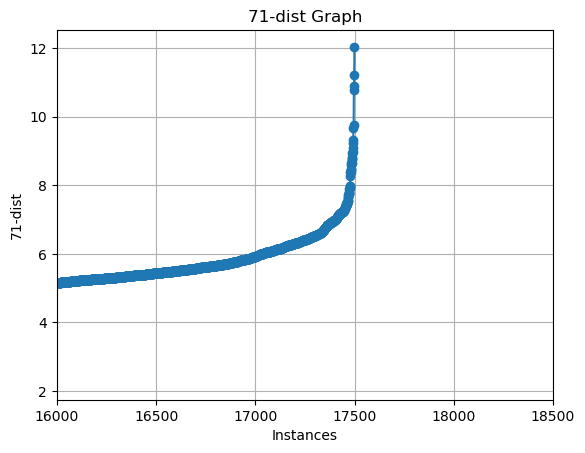

In [47]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
X_eps = scaler.fit_transform(db_fp)

# Set the desired value for 'k'
k = 71 # https://link.springer.com/article/10.1023/A:1009745219419, choose k= dimentionality of dataset*2 -1 = 36*2-1 = 71 >>>> epsilon = 8 

# Fit the k-nearest neighbors model
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_eps)

# Compute the distances to the kth nearest neighbor
distances, _ = knn.kneighbors(X_eps)
k_dist = np.mean(distances[:, -1])

# Plot the k-dist graph
plt.plot(np.sort(distances[:, -1]), marker='o')
plt.xlabel('Instances')
plt.ylabel(f'{k}-dist')
plt.title(f'{k}-dist Graph')
# Set the x-axis range to focus on the elbow region
plt.xlim(16000, 18500)
# Set y-axis display format to decimal
plt.grid(True)
plt.show()


In [48]:
# Normalize the data using StandardScaler
dbscan_scaled = scaler.fit_transform(db_fp)


Weight: 0.0
Feature cc_num: [-0.31761044 -0.31298059 -0.31759058 ... -0.31298059 -0.31298034
 -0.31489725]
Feature amt: [ 0.50119939  2.04152605 -0.80196183 ...  1.95728381  0.14583544
 -0.76788551]
Feature zip: [ 0. -0.  0. ... -0.  0. -0.]
Feature city_pop: [-0.31041452  0.281349   -0.31250465 ...  0.281349   -0.29793134
  0.02367697]
Feature merch_lat: [-1.47316816 -0.73404357 -0.87973175 ... -0.68845094 -0.91889391
 -2.11873403]
Feature merch_long: [-0.19205353  0.89170147 -0.43261434 ...  0.90006088 -0.12589784
  0.67363987]
Feature is_fraud: [0. 0. 0. ... 0. 0. 0.]
Feature gender_f: [-0.  0.  0. ...  0.  0.  0.]
Feature gender_m: [ 0. -0. -0. ... -0. -0. -0.]
Feature category_entertainment: [-0.20982888 -0.20982888 -0.20982888 ... -0.20982888 -0.20982888
 -0.20982888]
Feature category_food_dining: [-0.15235584 -0.15235584 -0.15235584 ... -0.15235584 -0.15235584
 -0.15235584]
Feature category_gas_transport: [-0.16612753 -0.16612753 -0.16612753 ... -0.16612753 -0.16612753
 -0.16612

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

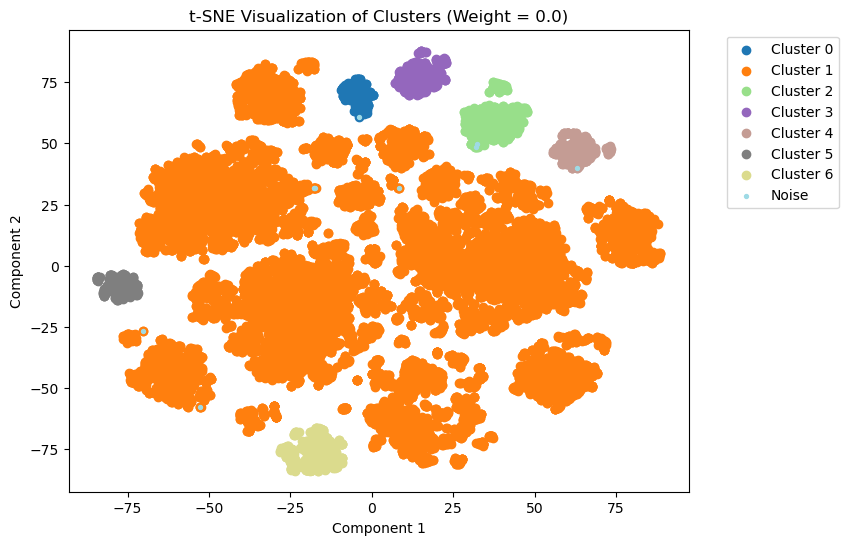

Feature Contributors for Weight: 0.0
Cluster -1:
  Top Features: Index(['category_home', 'merchant_freq', 'merch_long', 'city_pop', 'amt'], dtype='object')
Cluster 0:
  Top Features: Index(['amt', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_travel'],
      dtype='object')
Cluster 1:
  Top Features: Index(['category_grocery_net', 'category_kids_pets', 'category_food_dining',
       'category_gas_transport', 'category_home'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_misc_net', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_home'],
      dtype='object')
Cluster 3:
  Top Features: Index(['category_shopping_pos', 'category_misc_net', 'category_shopping_net',
       'hour', 'category_food_dining'],
      dtype='object')
Cluster 4:
  Top Features: Index(['merchant_freq', 'category_shopping_net', 'amt', 'hour',
       'category_kids_pets'],
      dtype='object')
Cluster 5:
  Top Features: Index(['city_freq', 'hour', 'street_fr

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

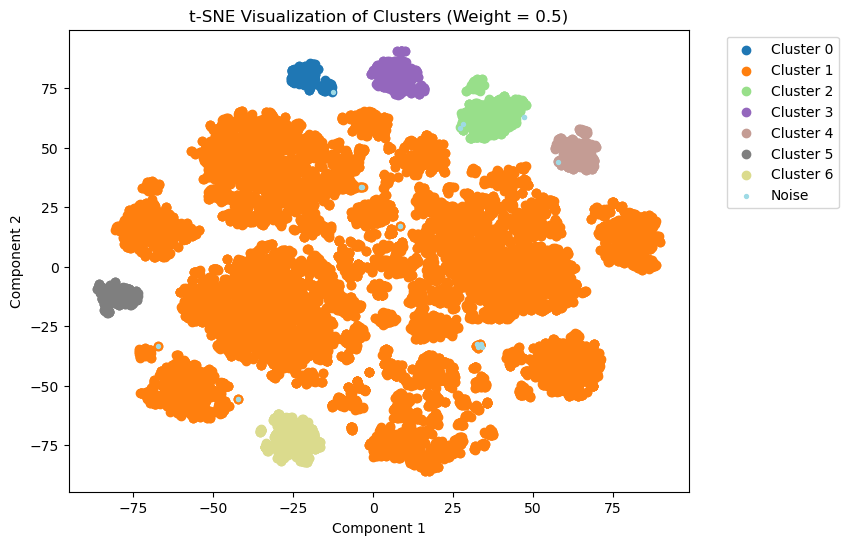

Feature Contributors for Weight: 0.5
Cluster -1:
  Top Features: Index(['category_home', 'city_pop', 'merch_lat', 'merch_long', 'amt'], dtype='object')
Cluster 0:
  Top Features: Index(['amt', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_travel'],
      dtype='object')
Cluster 1:
  Top Features: Index(['category_grocery_net', 'category_kids_pets', 'category_food_dining',
       'category_gas_transport', 'category_home'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_misc_net', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_home'],
      dtype='object')
Cluster 3:
  Top Features: Index(['category_shopping_pos', 'category_misc_net', 'category_shopping_net',
       'hour', 'category_food_dining'],
      dtype='object')
Cluster 4:
  Top Features: Index(['merchant_freq', 'category_shopping_net', 'amt', 'hour',
       'category_kids_pets'],
      dtype='object')
Cluster 5:
  Top Features: Index(['city_freq', 'hour', 'street_freq',

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

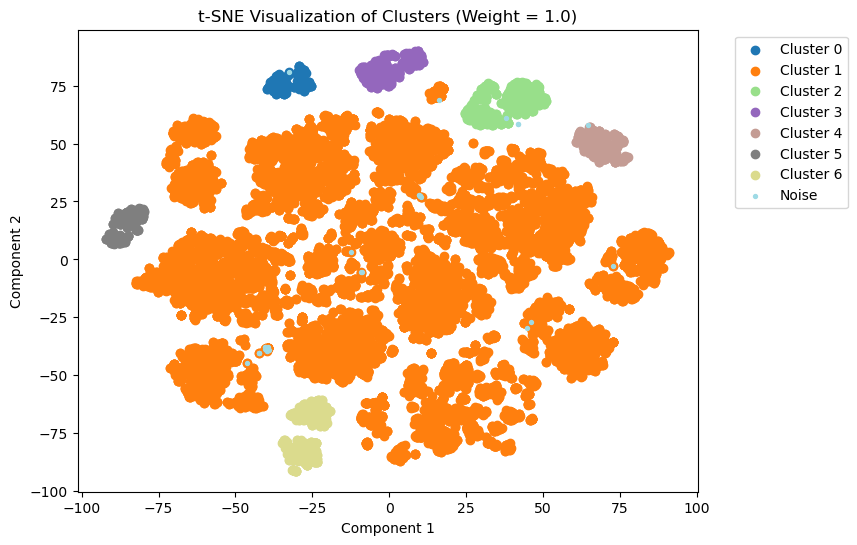

Feature Contributors for Weight: 1.0
Cluster -1:
  Top Features: Index(['zip', 'city_pop', 'merch_lat', 'merch_long', 'amt'], dtype='object')
Cluster 0:
  Top Features: Index(['age', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_travel'],
      dtype='object')
Cluster 1:
  Top Features: Index(['category_grocery_net', 'category_kids_pets', 'category_food_dining',
       'category_gas_transport', 'category_home'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_misc_net', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_home'],
      dtype='object')
Cluster 3:
  Top Features: Index(['category_shopping_pos', 'category_misc_net', 'category_shopping_net',
       'hour', 'category_food_dining'],
      dtype='object')
Cluster 4:
  Top Features: Index(['gender_m', 'gender_f', 'amt', 'hour', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['city_freq', 'hour', 'street_freq', 'merchant_freq',
       'category_grocer

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

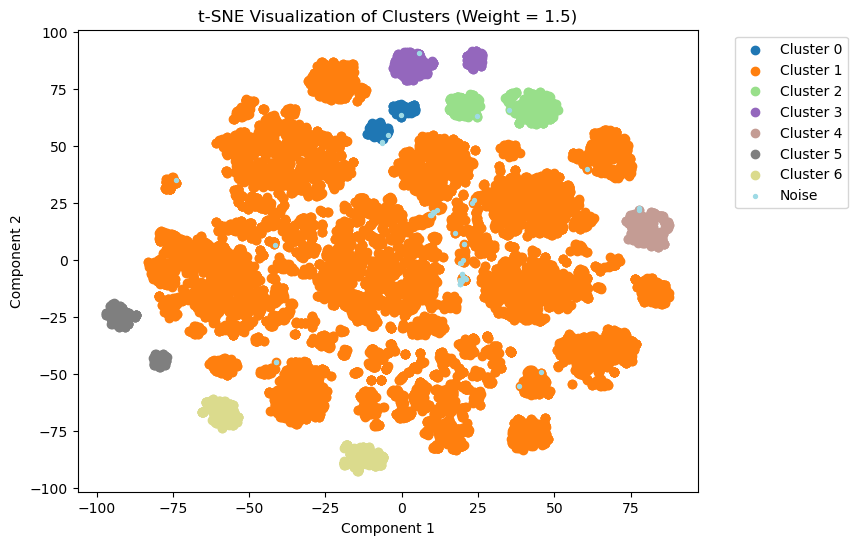

Feature Contributors for Weight: 1.5
Cluster -1:
  Top Features: Index(['gender_m', 'merch_lat', 'zip', 'merch_long', 'amt'], dtype='object')
Cluster 0:
  Top Features: Index(['category_shopping_net', 'age', 'hour', 'merchant_freq',
       'category_travel'],
      dtype='object')
Cluster 1:
  Top Features: Index(['category_grocery_net', 'category_kids_pets', 'category_food_dining',
       'category_gas_transport', 'category_home'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_misc_net', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_home'],
      dtype='object')
Cluster 3:
  Top Features: Index(['category_shopping_pos', 'category_misc_net', 'category_shopping_net',
       'hour', 'category_food_dining'],
      dtype='object')
Cluster 4:
  Top Features: Index(['amt', 'gender_m', 'gender_f', 'hour', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['city_freq', 'hour', 'street_freq', 'merchant_freq',
       'category_grocer

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

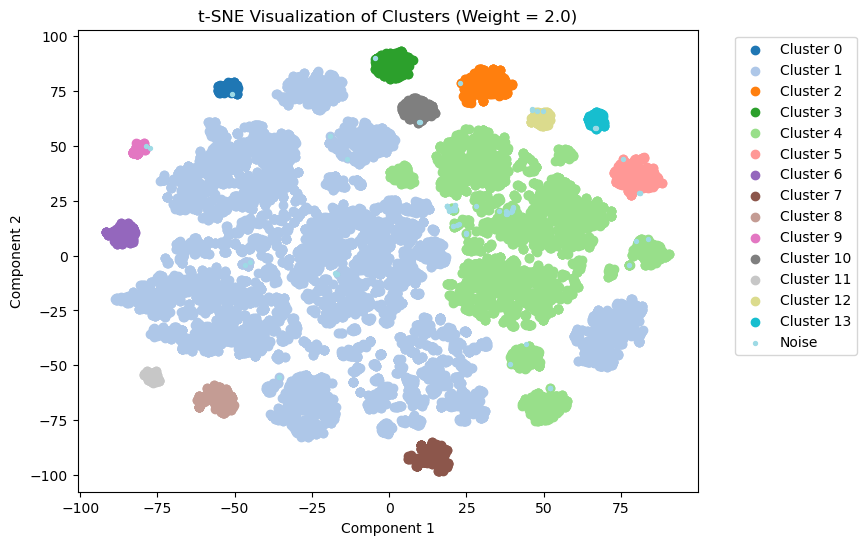

Feature Contributors for Weight: 2.0
Cluster -1:
  Top Features: Index(['gender_f', 'gender_m', 'zip', 'merch_long', 'amt'], dtype='object')
Cluster 0:
  Top Features: Index(['merchant_freq', 'age', 'gender_f', 'gender_m', 'category_travel'], dtype='object')
Cluster 1:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 3:
  Top Features: Index(['category_shopping_net', 'hour', 'gender_m', 'gender_f',
       'category_food_dining'],
      dtype='object')
Cluster 4:
  Top Features: Index(['category_grocery_pos', 'first_freq', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 5:
  Top Features: Index(['amt', 'hour', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 6:
  Top Features: Index(['street_freq', 'gender_m', 'gender_f', 'merchant_freq',
       'category_grocery_net'],
  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

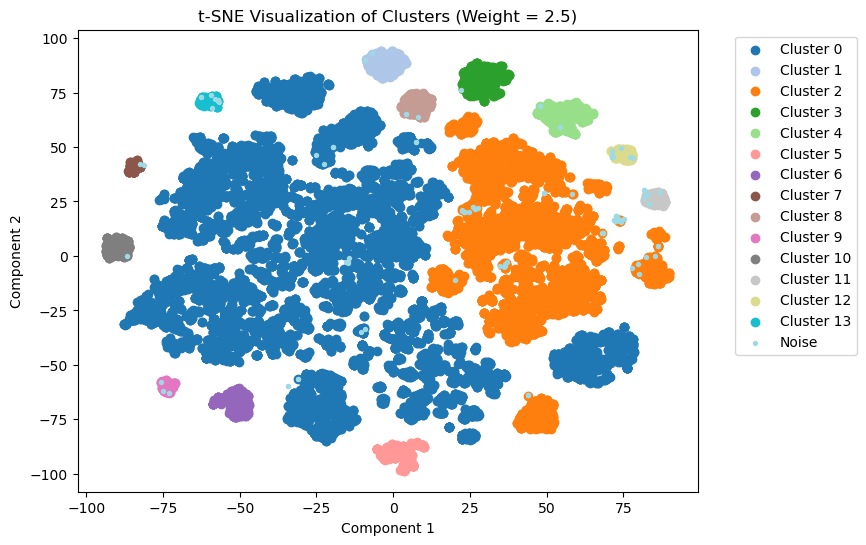

Feature Contributors for Weight: 2.5
Cluster -1:
  Top Features: Index(['merch_long', 'amt', 'zip', 'gender_m', 'gender_f'], dtype='object')
Cluster 0:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_shopping_net', 'hour', 'gender_m', 'gender_f',
       'category_food_dining'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_grocery_pos', 'first_freq', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 4:
  Top Features: Index(['amt', 'hour', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['age', 'hour', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 6:
  Top Features: Index(['age', 'hour', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 7:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

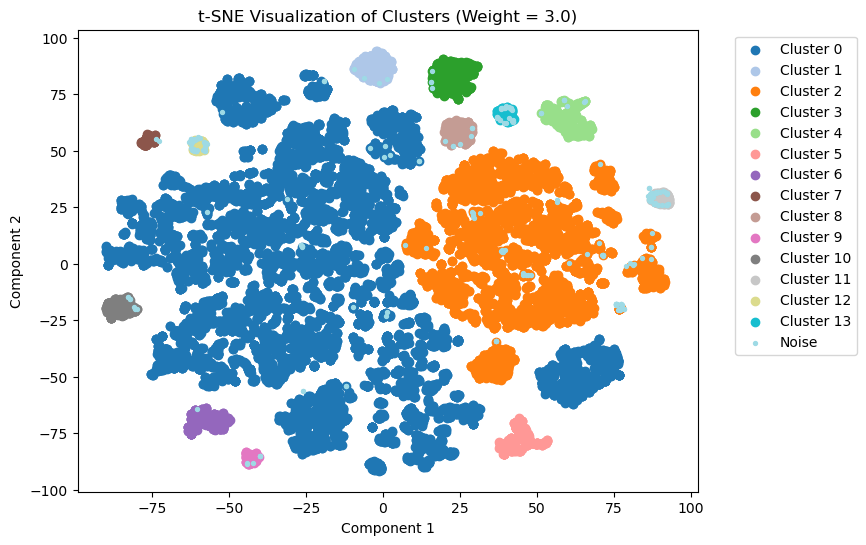

Feature Contributors for Weight: 3.0
Cluster -1:
  Top Features: Index(['zip', 'age', 'gender_m', 'gender_f', 'category_travel'], dtype='object')
Cluster 0:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_shopping_net', 'hour', 'gender_m', 'gender_f',
       'category_food_dining'],
      dtype='object')
Cluster 2:
  Top Features: Index(['category_grocery_pos', 'first_freq', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 4:
  Top Features: Index(['amt', 'hour', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 6:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Clust

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

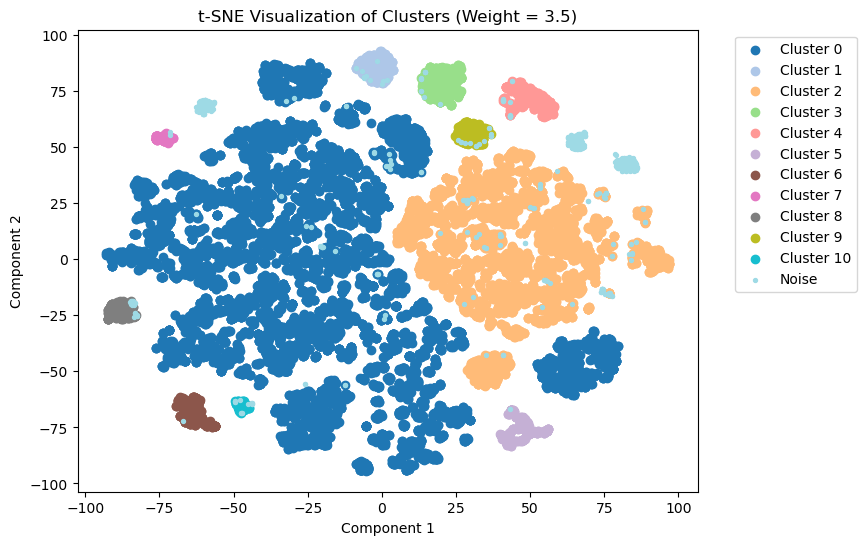

Feature Contributors for Weight: 3.5
Cluster -1:
  Top Features: Index(['category_food_dining', 'age', 'gender_m', 'gender_f',
       'category_travel'],
      dtype='object')
Cluster 0:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['zip', 'hour', 'gender_f', 'gender_m', 'category_food_dining'], dtype='object')
Cluster 2:
  Top Features: Index(['first_freq', 'zip', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 4:
  Top Features: Index(['age', 'hour', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['hour', 'age', 'gender_f', 'gender_m', 'category_gas_transport'], dtype='object')
Cluster 6:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 7:
  Top Featur

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

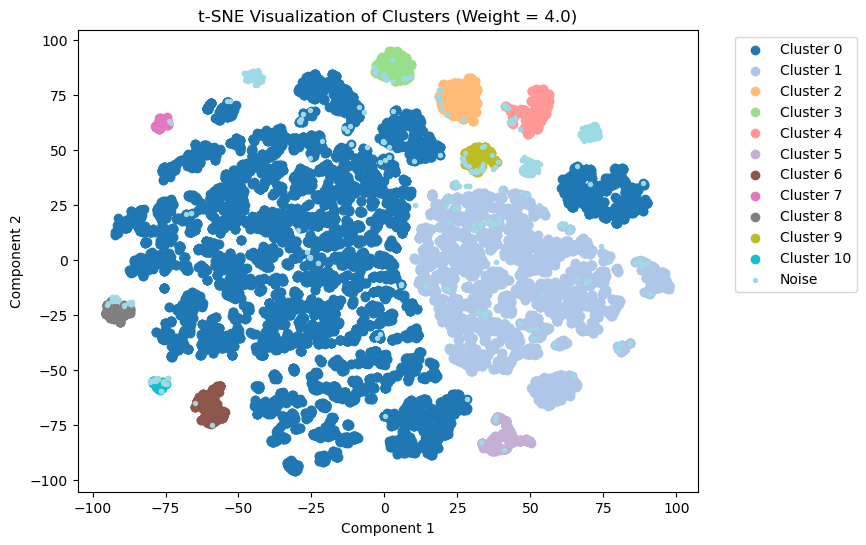

Feature Contributors for Weight: 4.0
Cluster -1:
  Top Features: Index(['zip', 'gender_m', 'gender_f', 'age', 'category_travel'], dtype='object')
Cluster 0:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['first_freq', 'zip', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'zip', 'gender_f', 'gender_m', 'category_food_dining'], dtype='object')
Cluster 4:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['hour', 'age', 'gender_f', 'gender_m', 'category_gas_transport'], dtype='object')
Cluster 6:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 7:
  Top Features: Index(['age', 'gender_f', 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

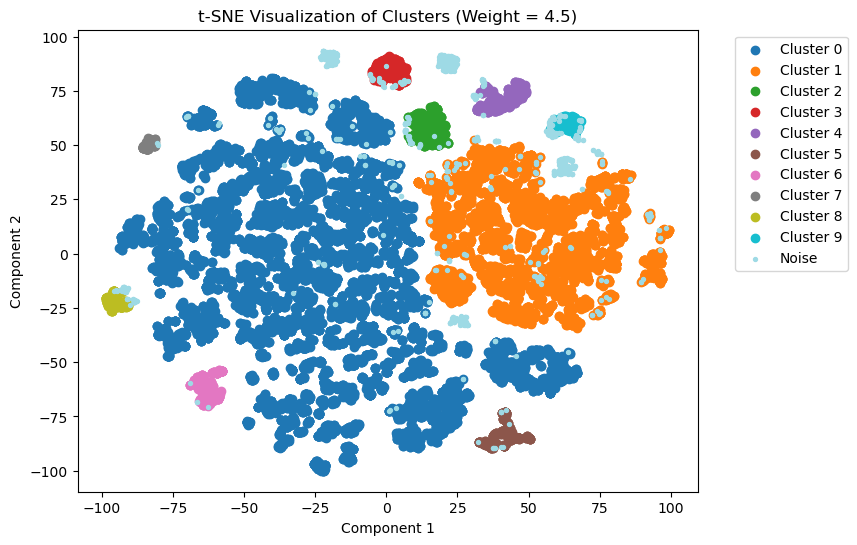

Feature Contributors for Weight: 4.5
Cluster -1:
  Top Features: Index(['zip', 'category_travel', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 0:
  Top Features: Index(['category_grocery_pos', 'category_home', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['first_freq', 'zip', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'zip', 'gender_m', 'gender_f', 'category_food_dining'], dtype='object')
Cluster 4:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 6:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 7:
  Top Features: Index(['age', 'gender_f', 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

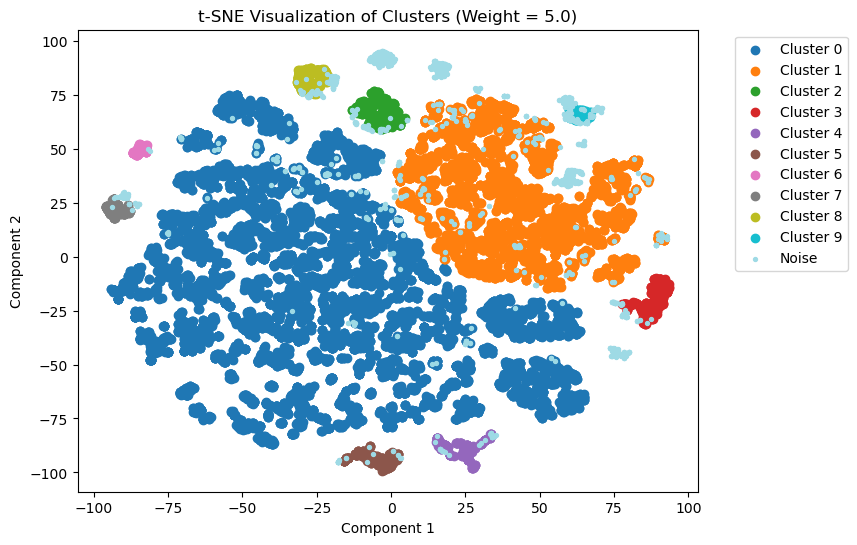

Feature Contributors for Weight: 5.0
Cluster -1:
  Top Features: Index(['zip', 'category_travel', 'gender_m', 'gender_f', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'zip', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'merchant_freq', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 4:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_gas_transport'], dtype='object')
Cluster 5:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 6:
  Top Features: Index(['age', 'gender_f', 'gender_m', 'zip', 'city_pop'], dtype='object')
Cluster 7:
  Top Features: Index(['zip', 'gender_m', 'gende

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

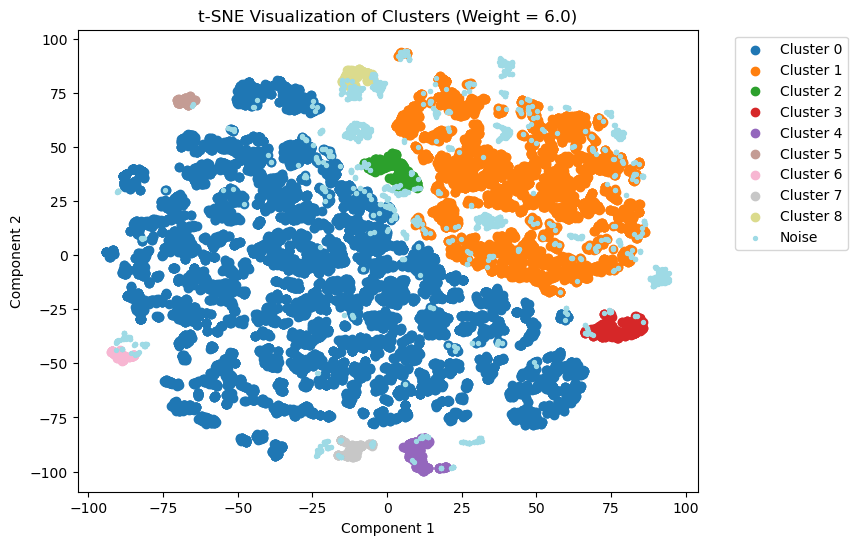

Feature Contributors for Weight: 6.0
Cluster -1:
  Top Features: Index(['category_travel', 'zip', 'gender_f', 'gender_m', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'zip', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 2:
  Top Features: Index(['zip', 'age', 'gender_m', 'gender_f', 'category_home'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'age', 'gender_m', 'gender_f', 'category_kids_pets'], dtype='object')
Cluster 4:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 5:
  Top Features: Index(['age', 'gender_m', 'gender_f', 'zip', 'city_pop'], dtype='object')
Cluster 6:
  Top Features: Index(['gender_m', 'gender_f', 'zip', 'age', 'category_grocery_net'], dtype='object')
Cluster 7:
  Top Features: Index(['zip', 'gender_m', 'gender_f', 'age', '

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

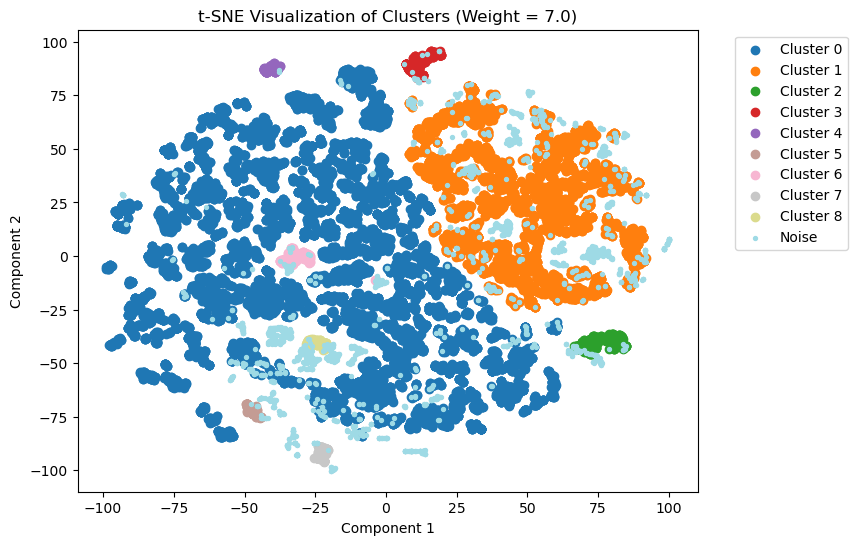

Feature Contributors for Weight: 7.0
Cluster -1:
  Top Features: Index(['category_home', 'zip', 'gender_m', 'gender_f', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'zip', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 2:
  Top Features: Index(['zip', 'gender_m', 'gender_f', 'age', 'category_kids_pets'], dtype='object')
Cluster 3:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 4:
  Top Features: Index(['age', 'gender_f', 'gender_m', 'zip', 'city_pop'], dtype='object')
Cluster 5:
  Top Features: Index(['gender_f', 'gender_m', 'zip', 'age', 'category_grocery_net'], dtype='object')
Cluster 6:
  Top Features: Index(['age', 'gender_m', 'gender_f', 'zip', 'category_home'], dtype='object')
Cluster 7:
  Top Features: Index(['zip', 'gender_f', 'gender_m', 'category_g

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

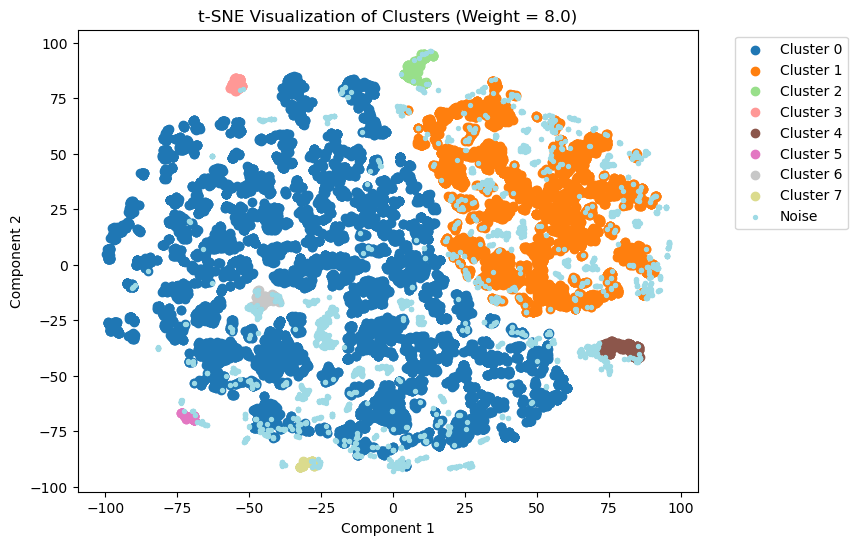

Feature Contributors for Weight: 8.0
Cluster -1:
  Top Features: Index(['category_home', 'zip', 'gender_m', 'gender_f', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'zip', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 3:
  Top Features: Index(['age', 'gender_f', 'gender_m', 'zip', 'city_pop'], dtype='object')
Cluster 4:
  Top Features: Index(['zip', 'gender_m', 'gender_f', 'age', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['gender_f', 'gender_m', 'zip', 'category_grocery_net', 'age'], dtype='object')
Cluster 6:
  Top Features: Index(['gender_f', 'gender_m', 'category_home', 'age', 'zip'], dtype='object')
Cluster 7:
  Top Features: Index(['zip', 'gender_f', 'gender_m', 'category_g

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

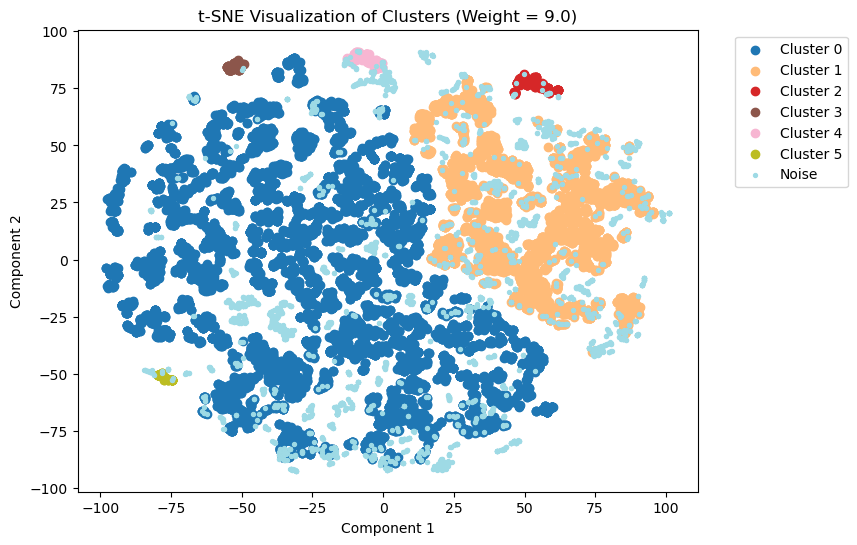

Feature Contributors for Weight: 9.0
Cluster -1:
  Top Features: Index(['category_home', 'zip', 'gender_f', 'gender_m', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'zip', 'age', 'gender_f', 'gender_m'], dtype='object')
Cluster 2:
  Top Features: Index(['hour', 'age', 'category_gas_transport', 'gender_f', 'gender_m'], dtype='object')
Cluster 3:
  Top Features: Index(['age', 'gender_f', 'gender_m', 'city_pop', 'zip'], dtype='object')
Cluster 4:
  Top Features: Index(['gender_f', 'gender_m', 'zip', 'age', 'category_kids_pets'], dtype='object')
Cluster 5:
  Top Features: Index(['gender_f', 'gender_m', 'category_grocery_net', 'zip', 'age'], dtype='object')
Weight: 9.0, Silhouette Score: -0.17933593876477377
Weight: 10.0
Feature cc_num: [-0.31761044 -0.31298059 -0.31759058 ... -0.31298059 -0.31298034
 -0.31489725]
Feature amt: [ 0.50119

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

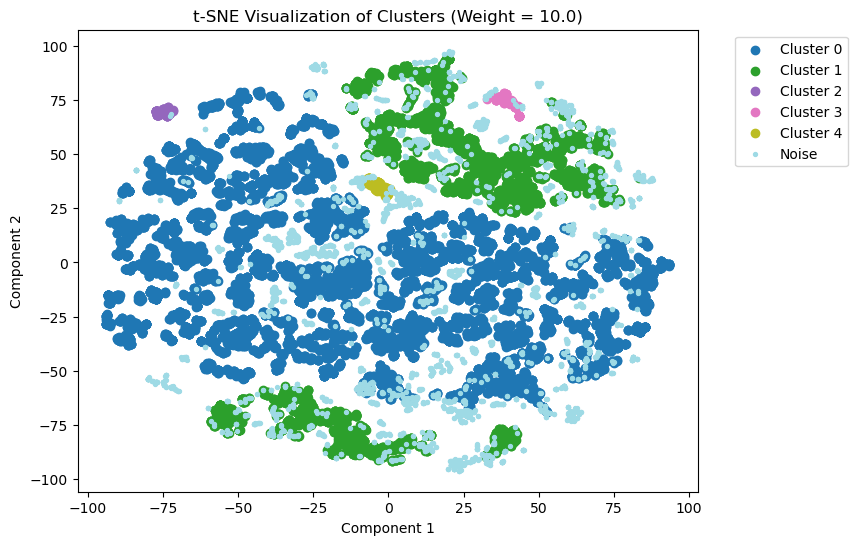

Feature Contributors for Weight: 10.0
Cluster -1:
  Top Features: Index(['category_home', 'zip', 'gender_f', 'gender_m', 'age'], dtype='object')
Cluster 0:
  Top Features: Index(['category_home', 'category_grocery_pos', 'age', 'gender_m', 'gender_f'], dtype='object')
Cluster 1:
  Top Features: Index(['category_misc_net', 'age', 'zip', 'gender_m', 'gender_f'], dtype='object')
Cluster 2:
  Top Features: Index(['age', 'gender_f', 'gender_m', 'city_pop', 'zip'], dtype='object')
Cluster 3:
  Top Features: Index(['zip', 'age', 'category_gas_transport', 'gender_m', 'gender_f'], dtype='object')
Cluster 4:
  Top Features: Index(['zip', 'gender_m', 'gender_f', 'category_kids_pets', 'age'], dtype='object')
Weight: 10.0, Silhouette Score: -0.21623650982804887


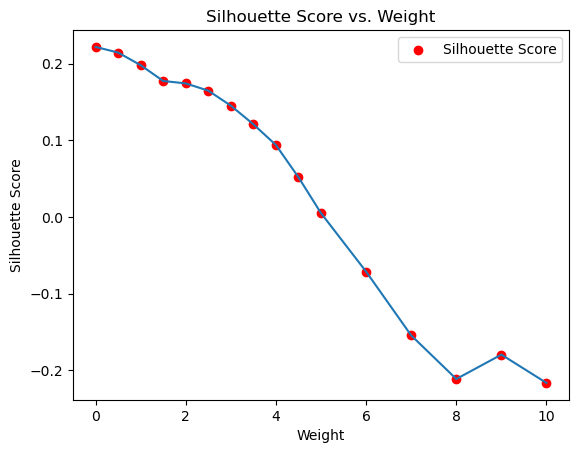

In [65]:
########################
########################
###FINAL DBSCAN MODEL###
########################
########################


# Assign weights to features
weight_range = np.concatenate([np.arange(0.0, 5.5, 0.5), np.arange(6,11,1)])
features = [2, 7, 8, 30]

# empty list to store silhouette scores, which are later used to plot the graph
silhouette_scores_list = []

# Create a nested dictionary to store feature contributors, so we can see what features contribute to the clusters
feature_contributors = {}


for weight in weight_range:
    dbscan_fp_weighted = dbscan_scaled.copy()
    for feature in features:
        dbscan_fp_weighted[:, feature] = dbscan_fp_weighted[:, feature] * weight

    # Create an instance of DBSCAN
    dbscan = DBSCAN(eps=6, min_samples=52)

    # Perform DBSCAN clustering
    clusters = dbscan.fit_predict(dbscan_fp_weighted)

    # Print the updated features
    print(f'Weight: {weight}')
    for feature_idx, feature_name in enumerate(db_fp.columns):
        updated_values = dbscan_fp_weighted[:, feature_idx]
        print(f'Feature {feature_name}: {updated_values}')
    print()


    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(dbscan_fp_weighted)  # Use the weighted dbscan_fp_scaled

    plt.figure(figsize=(8, 6))
    # Create a colormap with a number of colors equal to the number of clusters
    cmap = plt.cm.get_cmap('tab20', len(set(clusters)))

    # Create a scatter plot with different colors for each cluster
    for i, cluster_label in enumerate(set(clusters)):
        cluster_indices = np.where(clusters == cluster_label)[0]
        if cluster_label == -1:
            plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], c=cmap(i), label='Noise', s=8)
        else:
            plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], c=cmap(i), label=f'Cluster {cluster_label}')

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f't-SNE Visualization of Clusters (Weight = {weight})')

    # Adjust the legend position to be outside the plot area
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

    # Create nested dictionary for each weight
    feature_contributors[weight] = {}

    # Loop over clusters to get feature contributors
    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_fp_scaled = dbscan_fp_weighted[cluster_indices]
        feature_contributions = np.abs(cluster_fp_scaled.mean(axis=0))
        top_features_indices = np.argsort(feature_contributions)[-5:]
        top_features_names = db_fp.columns[top_features_indices]
        feature_contributors[weight][cluster_id] = {
            'Top Features': top_features_names,
            'Mean Values': feature_contributions[top_features_indices]
        }


    # Print feature contributors for each weight
    print(f"Feature Contributors for Weight: {weight}")
    for cluster_id, contributors in feature_contributors[weight].items():
        print(f"Cluster {cluster_id}:")
        print(f"  Top Features: {contributors['Top Features']}")

    # Compute silhouette score
    silhouette = silhouette_score(dbscan_fp_weighted, clusters)
    silhouette_scores_list.append(silhouette)

    # Print the silhouette score for each weight
    print(f'Weight: {weight}, Silhouette Score: {silhouette}')

# Plot the silhouette scores
plt.plot(weight_range, silhouette_scores_list)
plt.scatter(weight_range, silhouette_scores_list, color='red', label='Silhouette Score')
plt.xlabel('Weight')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Weight')
plt.legend()
plt.show()
   


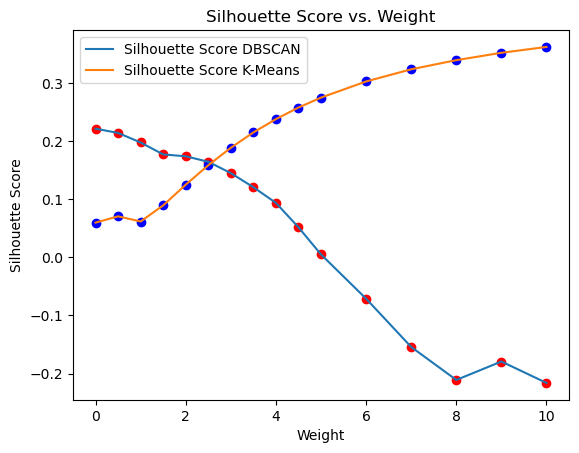

In [372]:
# Plot the silhouette scores
plt.plot(weight_range, silhouette_scores_list, label='Silhouette Score DBSCAN')
plt.scatter(weight_range, silhouette_scores_list, color='red')
plt.plot(weight_range, silhouette_scores_km, label='Silhouette Score K-Means')
plt.scatter(weight_range, silhouette_scores_km, color='blue')
plt.xlabel('Weight')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Weight')
plt.legend()
plt.show()


In [367]:
########################
########################
###FINAL DBSCAN MODEL###
########################
########################

# Assign weights to features
weight_range = np.concatenate([np.arange(0.0, 5.5, 0.5), np.arange(6, 11, 1)])
features = [2, 7, 8, 30]

# Create a nested dictionary to store feature contributors, so we can see what features contribute to the clusters
feature_contributors = {}

for weight in weight_range:
    dbscan_fp_weighted = dbscan_scaled.copy()
    for feature in features:
        dbscan_fp_weighted[:, feature] = dbscan_fp_weighted[:, feature] * weight

    # Create an instance of DBSCAN
    dbscan = DBSCAN(eps=6, min_samples=52)

    # Perform DBSCAN clustering
    clusters = dbscan.fit_predict(dbscan_fp_weighted)

    # Create nested dictionary for each weight
    feature_contributors[weight] = {}

    # Loop over clusters to get feature contributors
    for cluster_id in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster_id)[0]
        cluster_fp_scaled = dbscan_fp_weighted[cluster_indices]
        feature_contributions = np.abs(cluster_fp_scaled.mean(axis=0))
        top_features_indices = np.argsort(feature_contributions)[-5:]
        top_features_names = db_fp.columns[top_features_indices]
        feature_contributors[weight][cluster_id] = {
            'Top Features': top_features_names,
            'Mean Values': feature_contributions[top_features_indices]
        }

        # Print feature contributors for each cluster
        print(f"Feature Contributors for Weight: {weight}")
        print(f"Cluster {cluster_id}:")
        print(f"  Top Features: {top_features_names}")
        print("  Mean Values:")
        for feature, mean_value in zip(top_features_names, feature_contributions[top_features_indices]):
            print(f"    {feature}: {mean_value}")
        print()


Feature Contributors for Weight: 0.0
Cluster -1:
  Top Features: Index(['category_home', 'merchant_freq', 'merch_long', 'city_pop', 'amt'], dtype='object')
  Mean Values:
    category_home: 0.9288390745586002
    merchant_freq: 1.0248702180155773
    merch_long: 1.0642527199894078
    city_pop: 2.801046766411154
    amt: 5.572488752303646

Feature Contributors for Weight: 0.0
Cluster 0:
  Top Features: Index(['amt', 'category_shopping_net', 'hour', 'merchant_freq',
       'category_travel'],
      dtype='object')
  Mean Values:
    amt: 0.498582550695003
    category_shopping_net: 0.5502379986268516
    hour: 0.9766776129543866
    merchant_freq: 1.4911630362858543
    category_travel: 8.357643353790026

Feature Contributors for Weight: 0.0
Cluster 1:
  Top Features: Index(['category_grocery_net', 'category_kids_pets', 'category_food_dining',
       'category_gas_transport', 'category_home'],
      dtype='object')
  Mean Values:
    category_grocery_net: 0.12232522763270032
    categor

In [95]:
# Assign weights to features
weight_range = np.concatenate([np.arange(0.0, 5.5, 0.5), np.arange(6, 11, 1)])
features = [2, 7, 8, 30]

# Perform DBSCAN clustering for the unweighted data
dbscan = DBSCAN(eps=6, min_samples=52)
clusters_unweighted = dbscan.fit_predict(dbscan_scaled)

# Perform DBSCAN clustering for each weight
for weight in weight_range:
    dbscan_fp_weighted = dbscan_scaled.copy()
    for feature in features:
        dbscan_fp_weighted[:, feature] = dbscan_fp_weighted[:, feature] * weight

    # Perform DBSCAN clustering for the weighted data
    clusters_weighted = dbscan.fit_predict(dbscan_fp_weighted)

    # Perform the Kruskal-Wallis test comparing the clusters of weighted and unweighted data
    statistic, p_value = kruskal(clusters_weighted, clusters_unweighted)

    # Define the significance level
    alpha = 0.05

    # Print the test results for the current weight variation
    print(f"Weight: {weight}")
    print("Kruskal-Wallis Test")
    print(f"Test Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Interpret the test results for the current weight variation
    if p_value < alpha:
        print("There are significant differences in the clustering of false positives for this weight variation compared to the unweighted data.")
    else:
        print("There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.")

    print()


Weight: 0.0
Kruskal-Wallis Test
Test Statistic: 0.10531212751944852
P-value: 0.7455456693189214
There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 0.5
Kruskal-Wallis Test
Test Statistic: 0.028612127237143514
P-value: 0.8656777161786491
There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 1.0
Kruskal-Wallis Test
Test Statistic: 4.1829961941300986e-11
P-value: 0.9999948395948949
There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 1.5
Kruskal-Wallis Test
Test Statistic: 0.09772760677682883
P-value: 0.7545738264536412
There is no significant difference in the clustering of false positives for this weight variation compared to the unweighted data.

Weight: 2.0
Kruskal-Wallis Test
Test Statistic: 3303.7647217525114
P-value: 0.0
Ther